# Exploation_3

## 1. Kaggle(House Price Prediction)

### 1.1 모듈 설정

- 실습을 위해 필요한 환경들을 구성한다(missingno, lightgbm, xgboost 업그레이드)

In [2]:
!pip install --upgrade missingno
!pip install --upgrade lightgbm
!pip install --upgrade xgboost
!pip install uszipcode

     |████████████████████████████████| 2.0 MB 4.2 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


     |████████████████████████████████| 192.9 MB 53 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


     |████████████████████████████████| 76 kB 3.2 MB/s 
     |████████████████████████████████| 120 kB 24.0 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
     |████████████████████████████████| 42 kB 882 kB/s 


- import할 라이브러리를 보기 편하게 모아놓습니다.

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join
from google.colab import drive

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from uszipcode.search import SearchEngine

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1.2 함수 정리

#### 1.2.1 models

- Gradientboostng regressoer 등 사용할 모델을 정리합니다.

In [ ]:
gboost = GradientBoostingRegressor(random_state=2022)
xgboost = XGBRegressor(random_state=2022)
lightgbm = LGBMRegressor(random_state=2022)
rdforest = RandomForestRegressor(random_state=2022)

models = [gboost, xgboost, lightgbm, rdforest]

#### 1.2.2 get_scores

- 오늘 사용할 모델의 학습과 예측을 편리하게 도와줄 함수를 만듭니다. 

In [ ]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=22, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

#### 1.2.3 my_GridSearch

- 그리드 탐색 후 결과를 저장하고 RMSLE까지 구하는 함수를 만듭니다.

In [ ]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

#### 1.2.4 RMSE

- RMSE 값을 구하는 함수입니다.

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#### 1.2.5 zco

- ZipCode 값을 City로 변환해주는 함수입니다.

In [ ]:
search = SearchEngine()

def zco(x):
    city = search.by_zipcode(x).major_city
    return city if city else 'None'

Download /root/.uszipcode/simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!


### 1.3 데이터 로드

- kaggle에서 제공하는 House Price Prediction 데이터를 사용합니다.

In [ ]:
train_data_path = pd.read_csv('https://raw.githubusercontent.com/Chae0220/AI_Study/main/data/house_train.csv')
test_data_path = pd.read_csv('https://raw.githubusercontent.com/Chae0220/AI_Study/main/data/house_test.csv')

### 1.4 House Price Prediction

#### 1.4.1 데이터 확인

##### - files
1) train : house의 정보와 target인 price를 포함하고 있습니다.  
2) test : train으로 학습한 모델을 가지고 price를 예측하기 위한 데이터입니다.

##### - columns
1) ID : 집을 구분하는 번호  
2) date : 집을 구매한 날짜  
3) price : 집의 가격(Target variable)  
4) bedrooms : 침실의 수  
5) bathrooms : 화장실의 수  
6) sqft_living : 주거 공간의 평방 피트(면적)  
7) sqft_lot : 부지의 평방 피트(면적)  
8) floors : 집의 층 수  
9) waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  
10) view : 집이 얼마나 좋아 보이는지의 정도  
11) condition : 집의 전반적인 상태  
12) grade : King County grading 시스템 기준으로 매긴 집의 등급  
13) sqft_above : 지하실을 제외한 평방 피트(면적)  
14) sqft_basement : 지하실의 평방 피트(면적)  
15) yr_built : 지어진 년도  
16) yr_renovated : 집을 재건축한 년도  
17) zipcode : 우편번호  
18) lat : 위도  
19) long : 경도  
20) sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 21) 집을 재건축했다면, 변화가 있을 수 있음)  
21) sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)  

In [ ]:
data = train_data_path
test = test_data_path
print('train data dim : {}'.format(data.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


- 직접 데이터를 불러와 확인합니다.

In [ ]:
print(data.tail(5))

          id             date      price  bedrooms  bathrooms  sqft_living  \
15030  15030  20141014T000000   610685.0         4       2.50         2520   
15031  15031  20150326T000000  1007500.0         4       3.50         3510   
15032  15032  20140521T000000   360000.0         3       2.50         1530   
15033  15033  20150223T000000   400000.0         4       2.50         2310   
15034  15034  20141015T000000   325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
15030      6023     2.0           0     0  ...      9        2520   
15031      7200     2.0           0     0  ...      9        2600   
15032      1131     3.0           0     0  ...      8        1530   
15033      5813     2.0           0     0  ...      8        2310   
15034      1076     2.0           0     0  ...      7        1020   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
15030              0      2014           

- id는 0번부터 존재하니 결측치가 없으면 총 15035개의 id값이 있습니다.

- 위도, 경도 값도 있으니 구글맵으로 id 15030의 위치도 확인해보겠습니다.

<img src = 'https://drive.google.com/uc?id=1f6AWWdht-ShlCBOraEctq6-ijResfqev' height = 533 width = 900>

- zipcode 하나만 입력했지만 주로 Seattle 인근을 대상으로 입력된 데이터라고 생각됩니다.

- 이번엔 제일 비싼집도 한번 보겠습니다. 7.7m dollar니까 원화로 약 95억~100억 사이일 것 같습니다.

In [ ]:
print(data.iloc[data['price'].idxmax()])

id                          5108
date             20141013T000000
price                  7700000.0
bedrooms                       6
bathrooms                    8.0
sqft_living                12050
sqft_lot                   27600
floors                       2.5
waterfront                     0
view                           3
condition                      4
grade                         13
sqft_above                  8570
sqft_basement               3480
yr_built                    1910
yr_renovated                1987
zipcode                    98102
lat                      47.6298
long                    -122.323
sqft_living15               3940
sqft_lot15                  8800
Name: 5108, dtype: object


495 900
<img src = "https://drive.google.com/uc?id=1So2t6kjMil2MnI50aQYzDo4XsgsTkVjP" height = 495 width = 900>

- 이 집인데요. 저는 잘 모르겠습니다.

#### 1.4.2 데이터 정리


1) 데이터 상관관계 확인

- 뒤에서 시각화를 다루겠지만, 그에 앞서 price와의 상관관계를 보고 싶어서 seaborn의 heatmap을 활용합니다.

In [ ]:
print(data.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


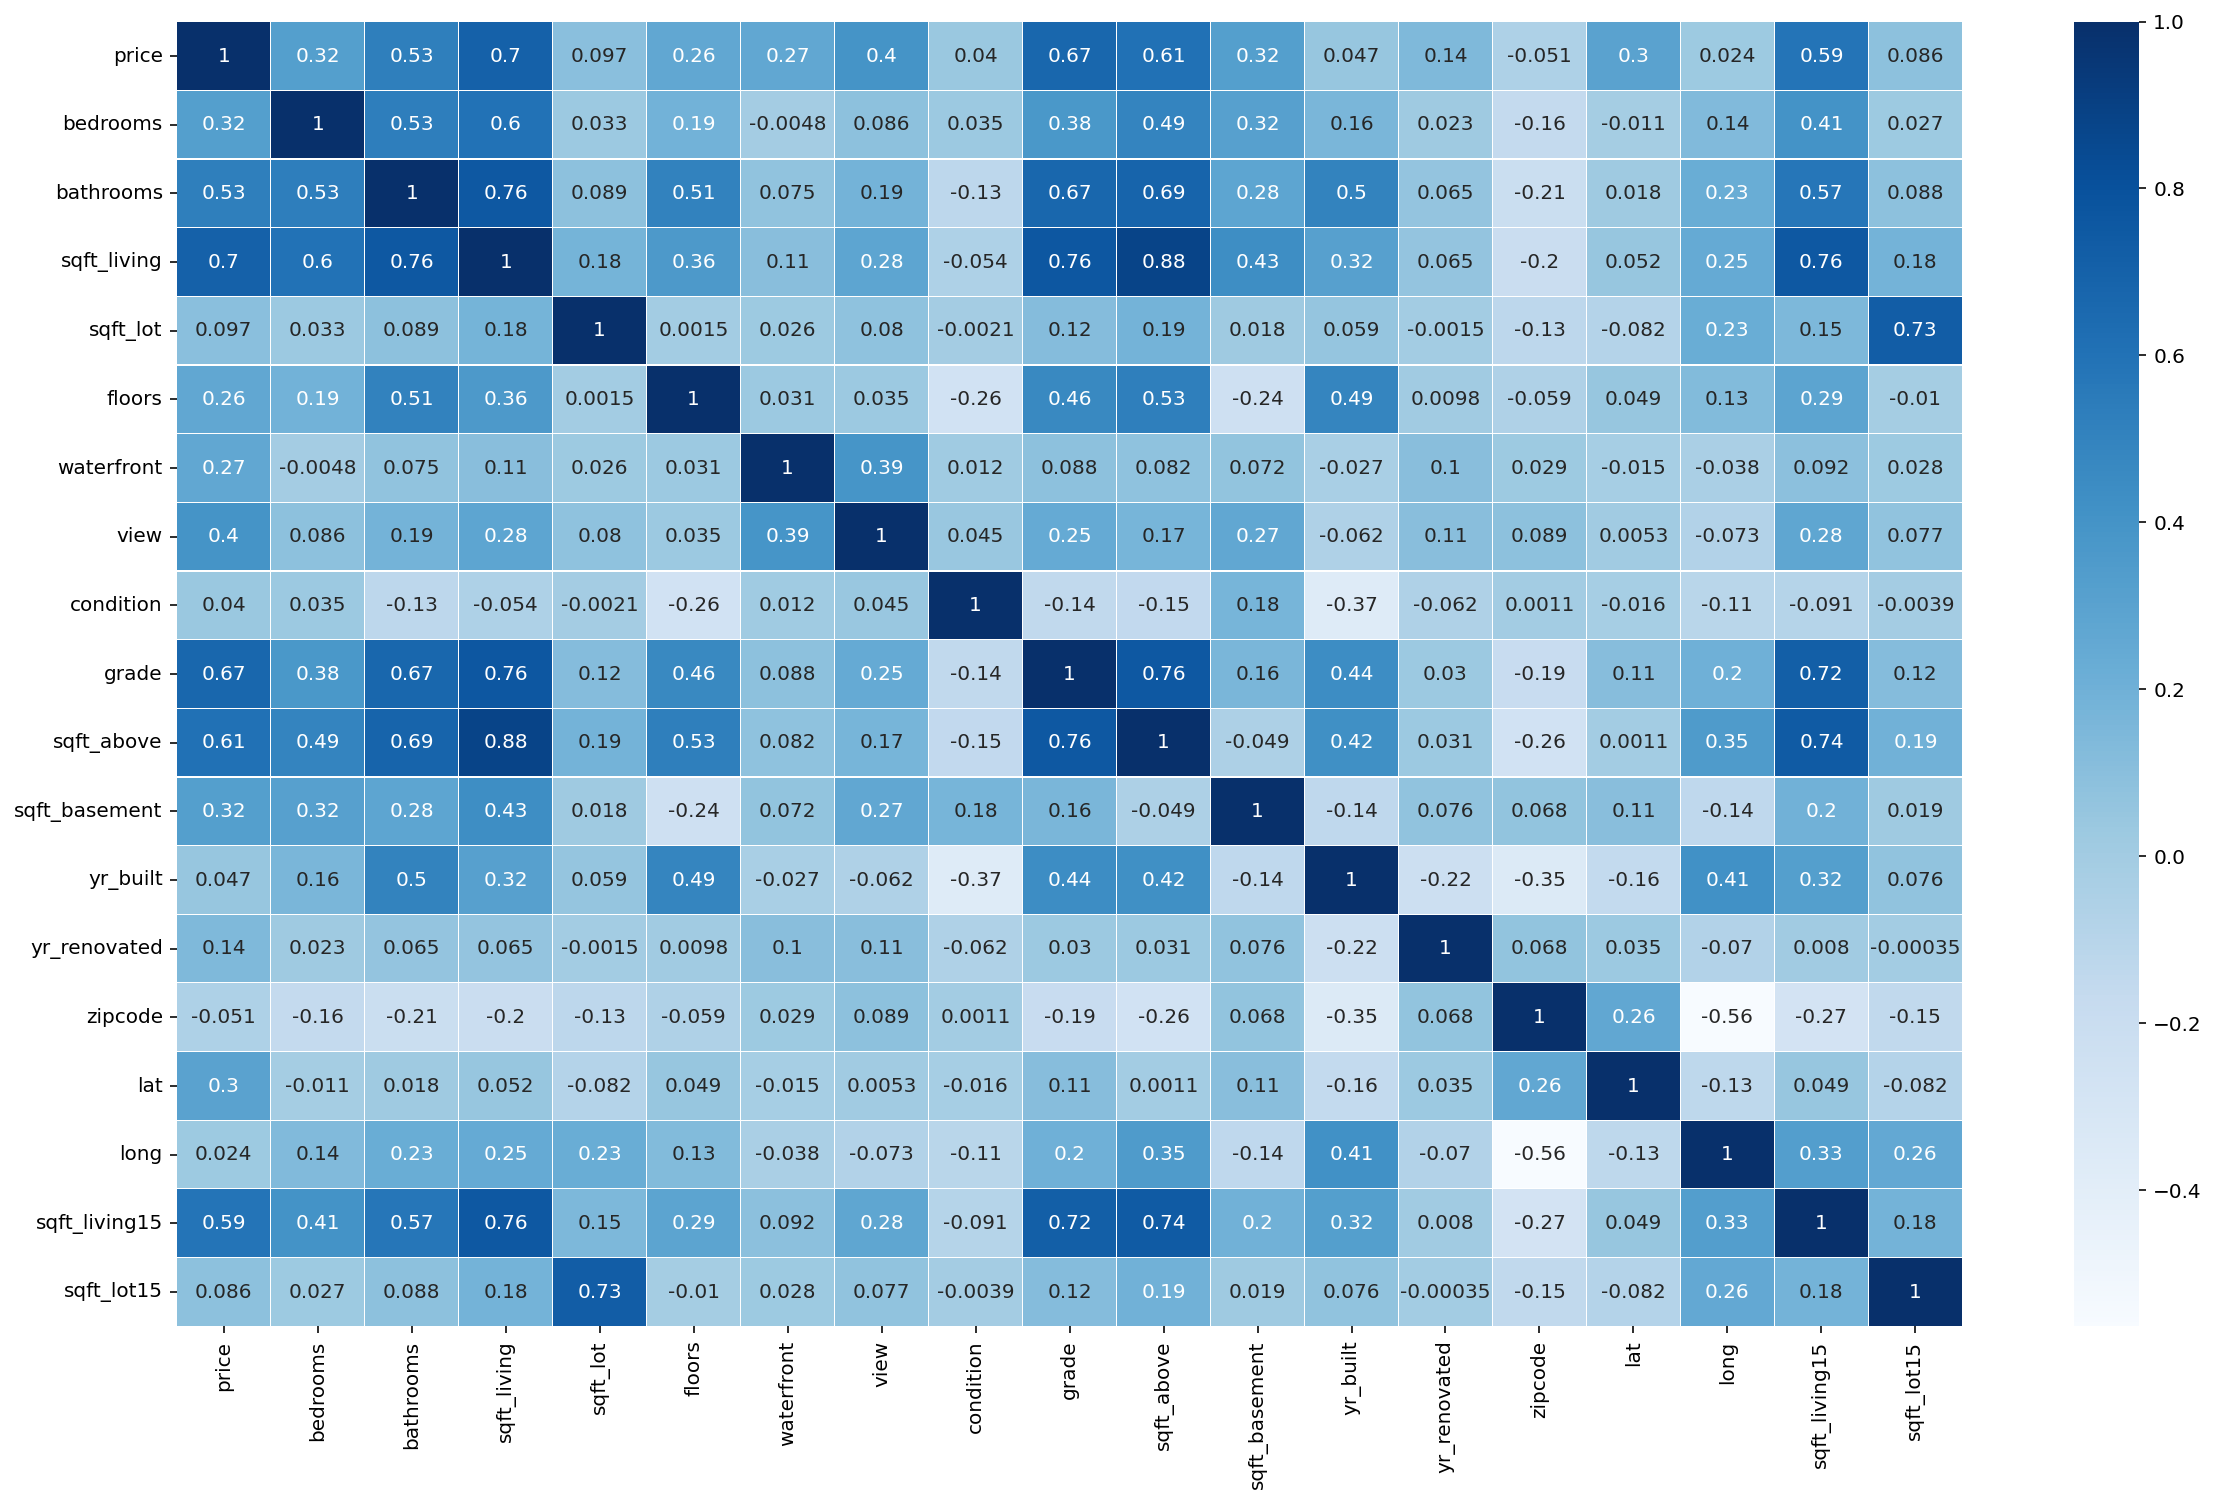

In [ ]:
corr_data = data[['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']].corr()
fig, ax = plt.subplots(figsize=(20,12))

sns.heatmap(data=corr_data, ax=ax, linewidths=0.1, linecolor='white', annot=True, cmap='Blues')
plt.show()

- 우리의 목적은 'Price'를 예측하는 것입니다.  
- price를 기준으로 상관관계가 높은 것은 sqft_living, grade, sqft_above, sqdt_living15, bathrooms, view, bedrooms, sqft_basement, waterfront, floors 정도로 보입니다.


2) Outliers 정리

- 이상치를 제거하기 위해 regplot을 이용합니다.
- y축에 'price'를 설정하여 살펴보고 가겠습니다.

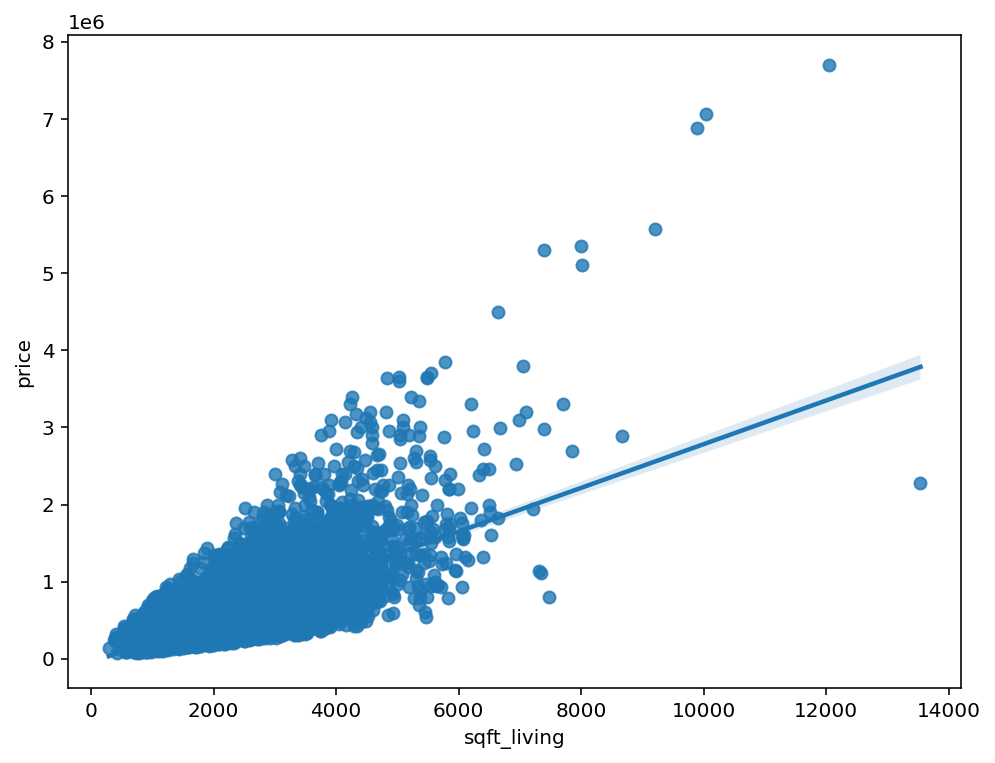

In [ ]:
out_sqft_living = pd.concat([data['price'], data['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=out_sqft_living)

- 주거 공간의 면적에 따른 outlier를 찾아보면 living이 14000값에 가까운데 price는 작습니다.
- 데이터를 불러와 살펴봅니다.

In [ ]:
pd.options.display.max_columns = None

data.loc[data['sqft_living'] > 9000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
3134,3134,20140804T000000,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
5108,5108,20141013T000000,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,6469,20140919T000000,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
8912,8912,20140505T000000,2280000.0,7,8.00,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [ ]:
data = data.drop(data[data['id']==8912].index)
data = data.drop(data[data['id']==2775].index)
data = data.drop(data[data['id']==5108].index)
data = data.drop(data[data['id']==6469].index)

- 위에서 drop된 데이터는 sqft_와 rooms 등의 데이터로 볼 때 outlier로 판단됩니다.

- grade 따른 outlier를 찾아보면 grade 11, 13에 튀는 값들이 보입니다.
- 하지만 무조건 제거할 수 없으니 다 살펴보고 제거합니다.

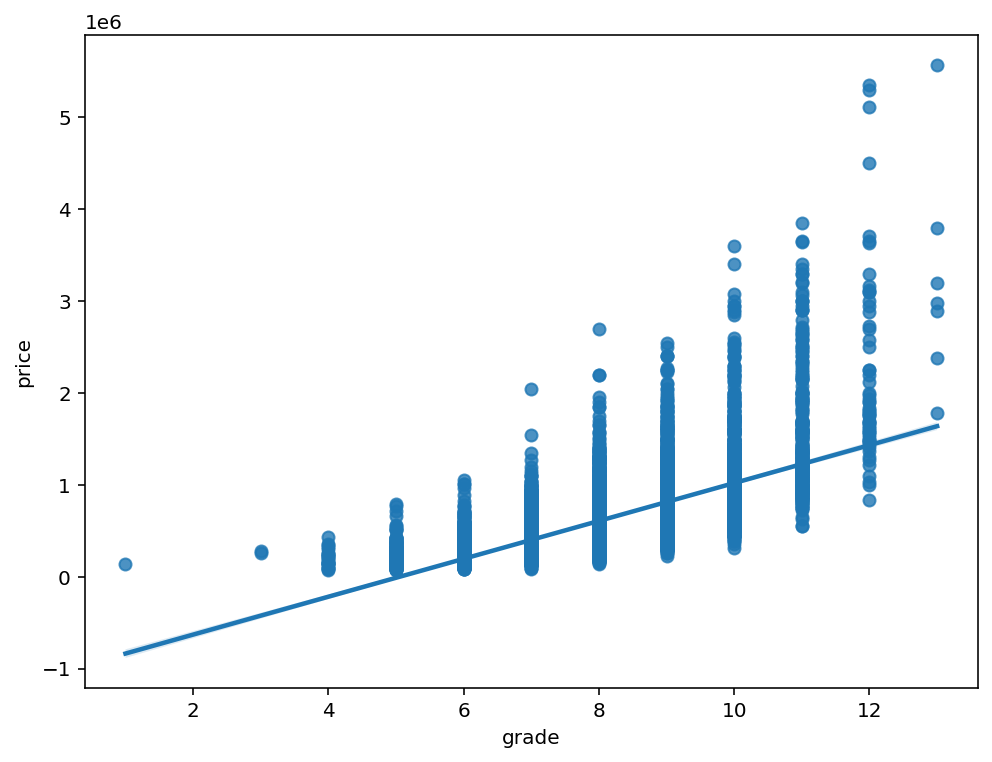

In [ ]:
out_grade= pd.concat([data['price'], data['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='grade', y="price", data=out_grade)

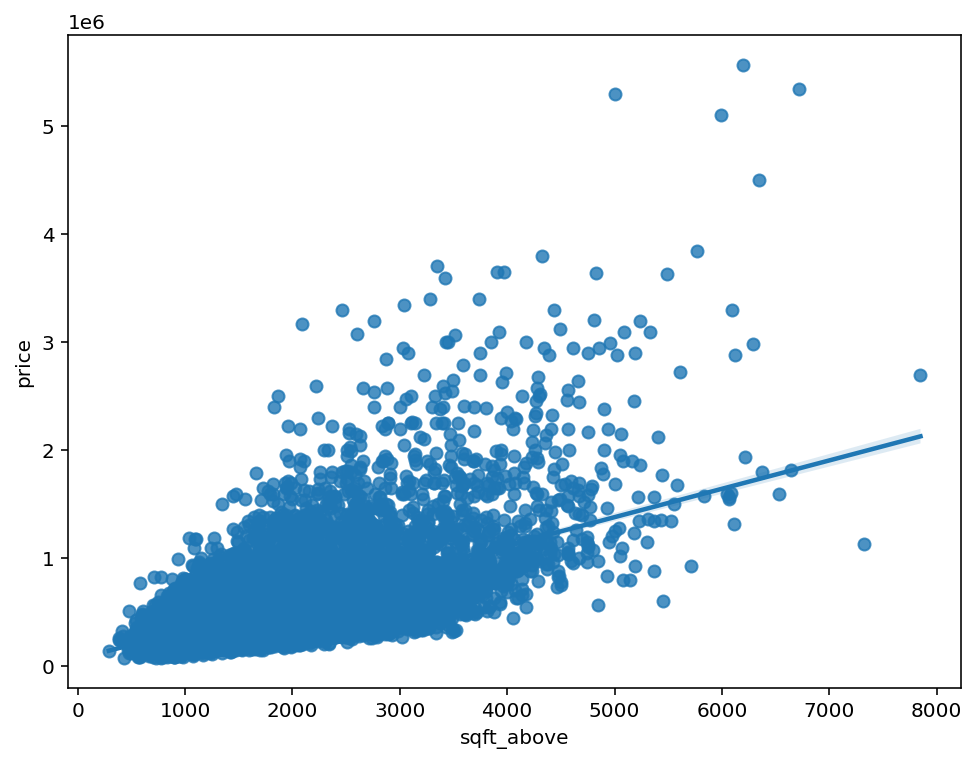

In [ ]:
out_sqft_above= pd.concat([data['price'], data['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=out_sqft_above)

- above 따른 outlier를 찾아보면 우측 최상단 부근에 outliers가 보입니다.
- 마찬가지로 확인하고 제거하겠습니다.

In [ ]:
above_out = data.loc[data['sqft_above'] > 6000]
above_out.sort_values(by=['sqft_above'], ascending=[False])

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
13809,13809,20150122T000000,2700000.0,4,4.00,7850,89651,2.0,0,0,3,12,7850,0,2006,0,98027,47.5406,-121.982,6210,95832
12921,12921,20140708T000000,1135250.0,5,4.00,7320,217800,2.0,0,0,3,11,7320,0,1992,0,98058,47.4473,-122.086,3270,34500
1045,1045,20150413T000000,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
7739,7739,20140627T000000,1820000.0,4,4.50,6640,53330,2.0,0,0,3,12,6640,0,1993,0,98077,47.7283,-122.046,4620,68625
14225,14225,20150415T000000,1600000.0,4,5.50,6530,871200,2.0,0,2,3,11,6530,0,2008,0,98014,47.6640,-121.878,1280,858132
14237,14237,20150123T000000,1800000.0,4,3.50,6370,205603,2.0,0,0,3,12,6370,0,2008,0,98027,47.5016,-121.905,1490,33580
1882,1882,20140815T000000,4500000.0,5,5.50,6640,40014,2.0,1,4,3,12,6350,290,2004,0,98155,47.7493,-122.280,3030,23408
7246,7246,20141212T000000,2983000.0,5,5.50,7400,18898,2.0,0,3,3,13,6290,1110,2001,0,98006,47.5431,-122.112,6110,26442
4592,4592,20150209T000000,1940000.0,4,5.75,7220,223462,2.0,0,4,3,12,6220,1000,2000,0,98053,47.7097,-122.013,2680,7593
3134,3134,20140804T000000,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345


- 1045, 1882, 3134, 12845 정도가 눈에 띕니다.
- rooms와, sqft_를 종합적으로 따져보면 
- 1045, 1882, 3134는 제거해도 될 이상치로 판단됩니다.

In [ ]:
data = data.drop(data[data['id']==1045].index)
data = data.drop(data[data['id']==1882].index)
data = data.drop(data[data['id']==3134].index)

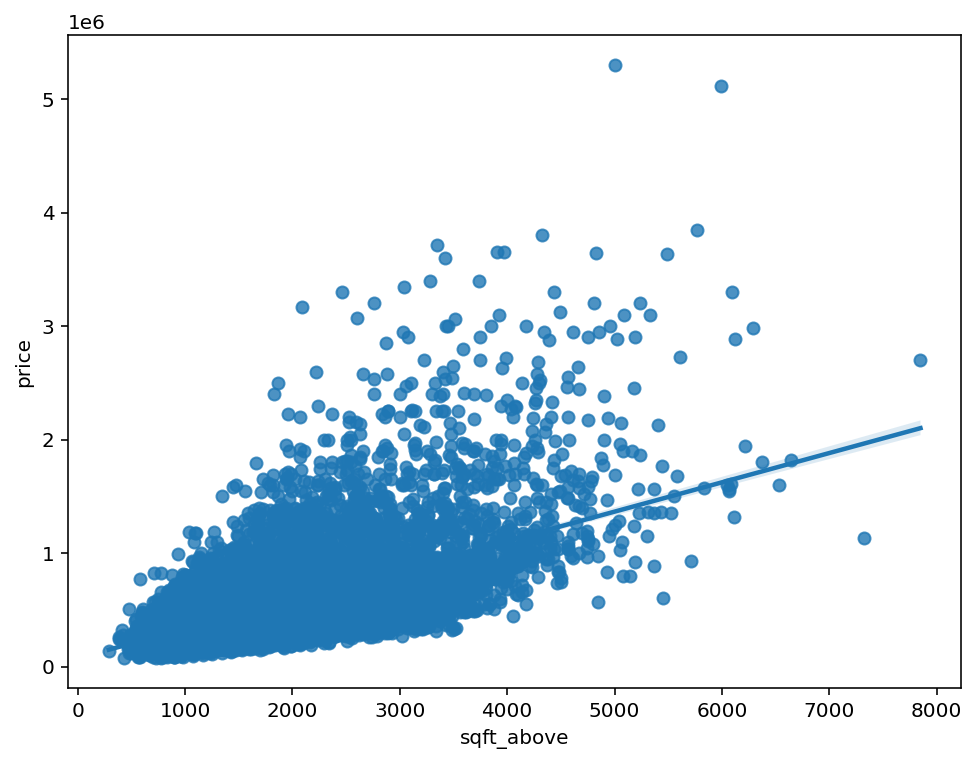

In [ ]:
out_sqft_above= pd.concat([data['price'], data['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=out_sqft_above)

- 다시 그려보니 price 상단부 값도 이상합니다. price로 뽑아봅니다.

In [ ]:
above_out = data.loc[data['price'] > 3500000]
above_out.sort_values(by=['price'], ascending=[False])

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
947,947,20150413T000000,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619
842,842,20141020T000000,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
1499,1499,20141114T000000,3850000.0,4,4.25,5770,21300,2.0,1,4,4,11,5770,0,1980,0,98040,47.5850,-122.222,4620,22748
4957,4957,20140701T000000,3800000.0,5,5.50,7050,42840,1.0,0,2,4,13,4320,2730,1978,0,98004,47.6229,-122.220,5070,20570
11364,11364,20140530T000000,3710000.0,4,3.50,5550,28078,2.0,0,2,4,12,3350,2200,2000,0,98039,47.6395,-122.234,2980,19602
4598,4598,20150421T000000,3650000.0,6,4.75,5480,19401,1.5,1,4,5,11,3910,1570,1936,0,98105,47.6515,-122.277,3510,15810
12848,12848,20150511T000000,3650000.0,5,3.75,5020,8694,2.0,0,1,3,12,3970,1050,2007,0,98004,47.6146,-122.213,4190,11275
10645,10645,20140911T000000,3640900.0,4,3.25,4830,22257,2.0,1,4,4,11,4830,0,1990,0,98039,47.6409,-122.241,3820,25582
13311,13311,20141011T000000,3635000.0,5,6.00,5490,19897,2.0,0,0,3,12,5490,0,2005,0,98039,47.6165,-122.236,2910,17600
2049,2049,20141118T000000,3600000.0,3,3.25,5020,12431,2.0,1,4,3,10,3420,1600,1941,2002,98144,47.5925,-122.287,3680,12620


- 4957번보다 grade가 높은 것도 아니고, 주거공간이나 부지가 넓은 것도 아니고, 최근 지어진 집도 아니고,  
전망이나 집 상태가 좋은 것도 아닙니다. 제거합니다.

In [ ]:
data = data.drop(data[data['id']==947].index)
data = data.drop(data[data['id']==842].index)

In [ ]:
above_out = data.loc[data['price'] > 3500000]
above_out.sort_values(by=['price'], ascending=[False])

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1499,1499,20141114T000000,3850000.0,4,4.25,5770,21300,2.0,1,4,4,11,5770,0,1980,0,98040,47.5850,-122.222,4620,22748
4957,4957,20140701T000000,3800000.0,5,5.50,7050,42840,1.0,0,2,4,13,4320,2730,1978,0,98004,47.6229,-122.220,5070,20570
11364,11364,20140530T000000,3710000.0,4,3.50,5550,28078,2.0,0,2,4,12,3350,2200,2000,0,98039,47.6395,-122.234,2980,19602
4598,4598,20150421T000000,3650000.0,6,4.75,5480,19401,1.5,1,4,5,11,3910,1570,1936,0,98105,47.6515,-122.277,3510,15810
12848,12848,20150511T000000,3650000.0,5,3.75,5020,8694,2.0,0,1,3,12,3970,1050,2007,0,98004,47.6146,-122.213,4190,11275
10645,10645,20140911T000000,3640900.0,4,3.25,4830,22257,2.0,1,4,4,11,4830,0,1990,0,98039,47.6409,-122.241,3820,25582
13311,13311,20141011T000000,3635000.0,5,6.00,5490,19897,2.0,0,0,3,12,5490,0,2005,0,98039,47.6165,-122.236,2910,17600
2049,2049,20141118T000000,3600000.0,3,3.25,5020,12431,2.0,1,4,3,10,3420,1600,1941,2002,98144,47.5925,-122.287,3680,12620


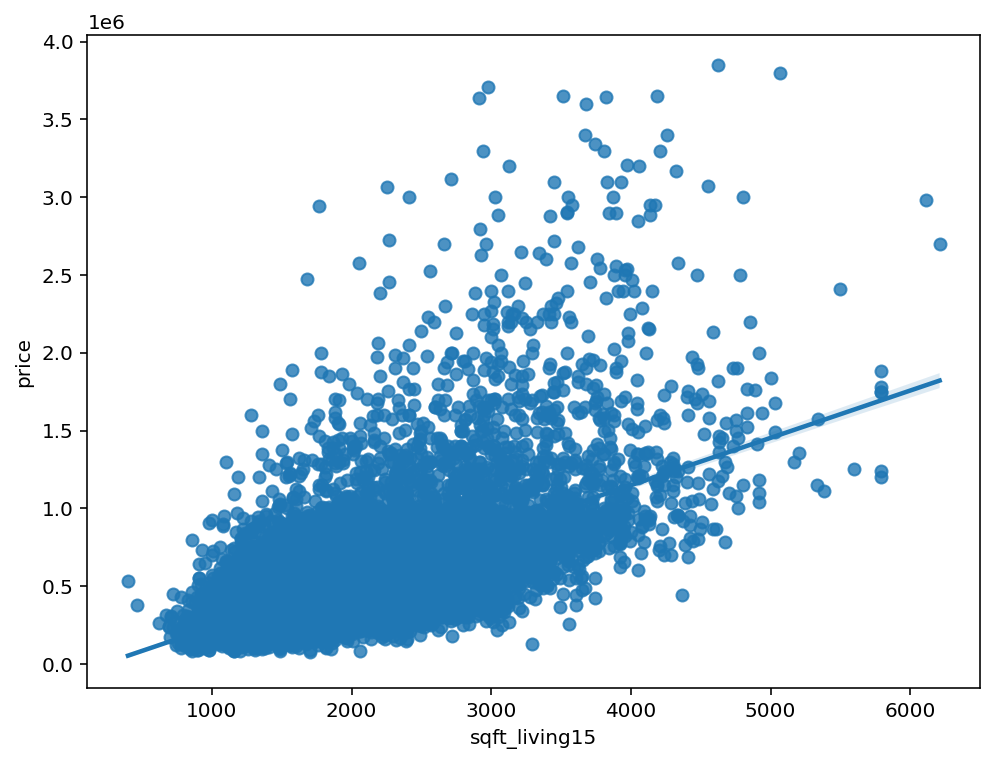

In [ ]:
out_sqft_living15 = pd.concat([data['price'], data['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=out_sqft_living15)

- 대게 outliers 어디서나 튑니다. 위에 값들을 수정하고 내려오니 다른 변수도 정리되는 것이 보입니다.

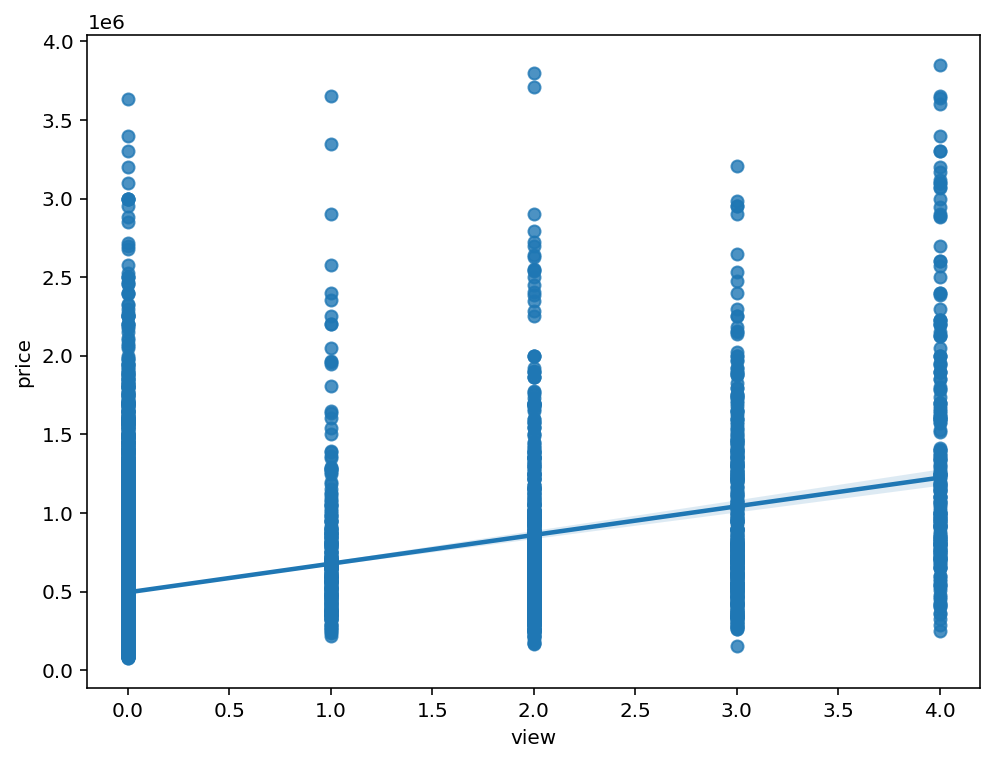

In [ ]:
out_view= pd.concat([data['price'], data['view']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='view', y="price", data=out_view)

- view 따른 outlier도 확인합니다.
- 이상치의 다른 데이터도 확인하고 제거하겠습니다.

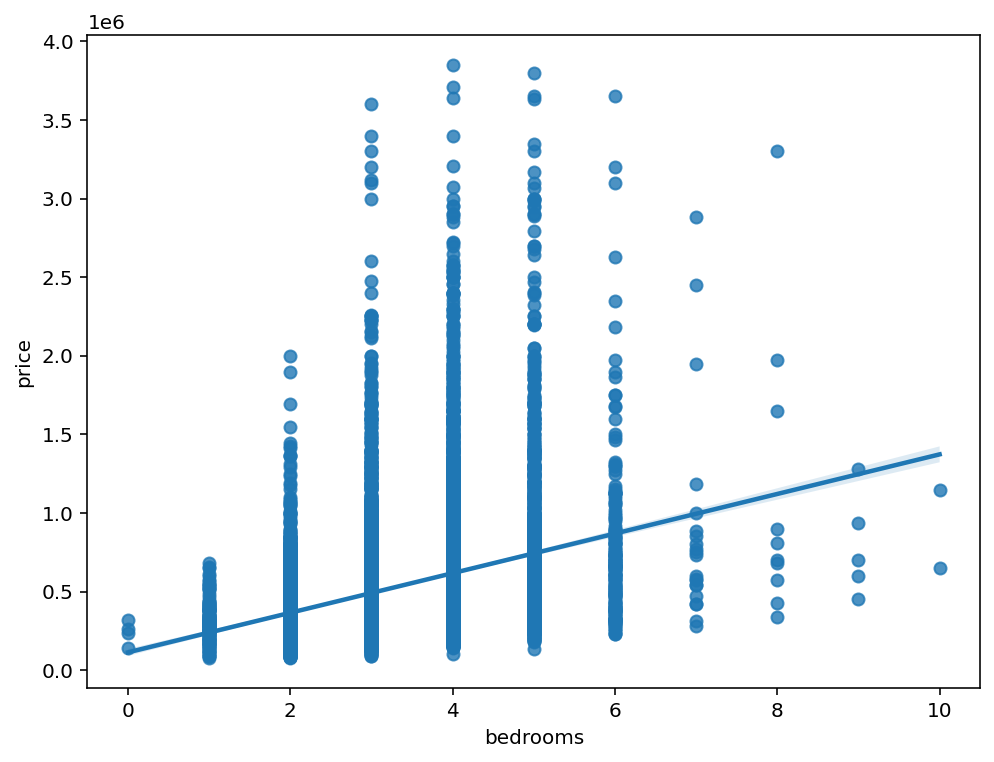

In [ ]:
out_bedrooms= pd.concat([data['price'], data['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='bedrooms', y="price", data=out_bedrooms)

- bedrooms도 다른 데이터를 확인하고 제거하겠습니다.

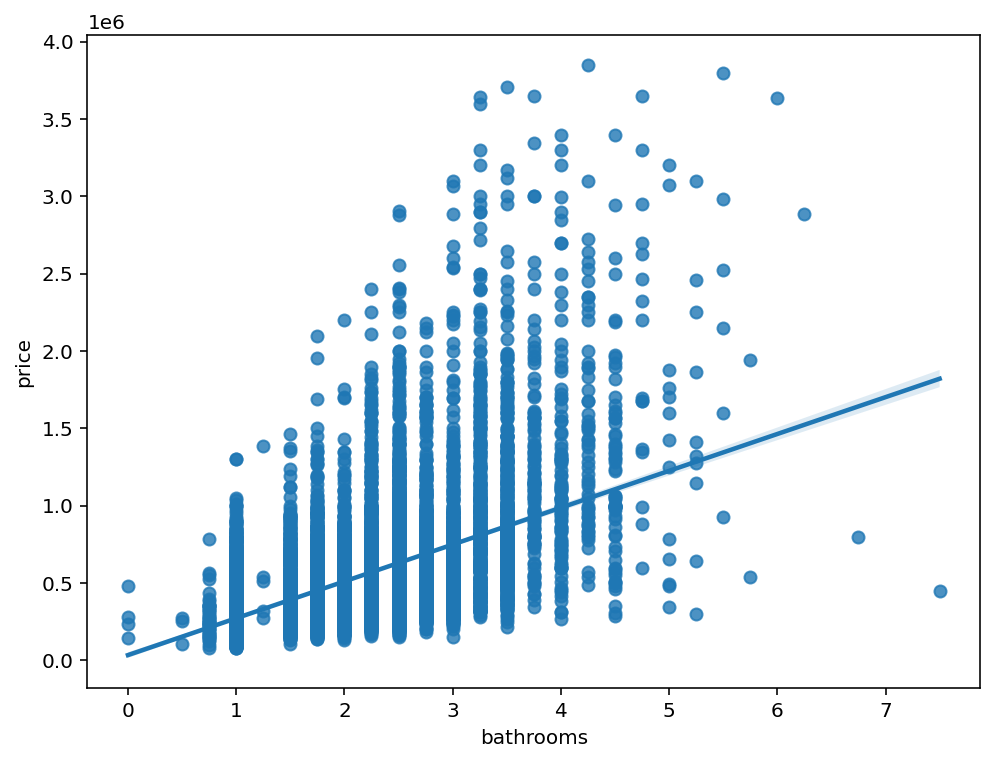

In [ ]:
out_bathrooms= pd.concat([data['price'], data['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='bathrooms', y="price", data=out_bathrooms)

- bathrooms도 다른 데이터를 확인하고 제거하겠습니다.

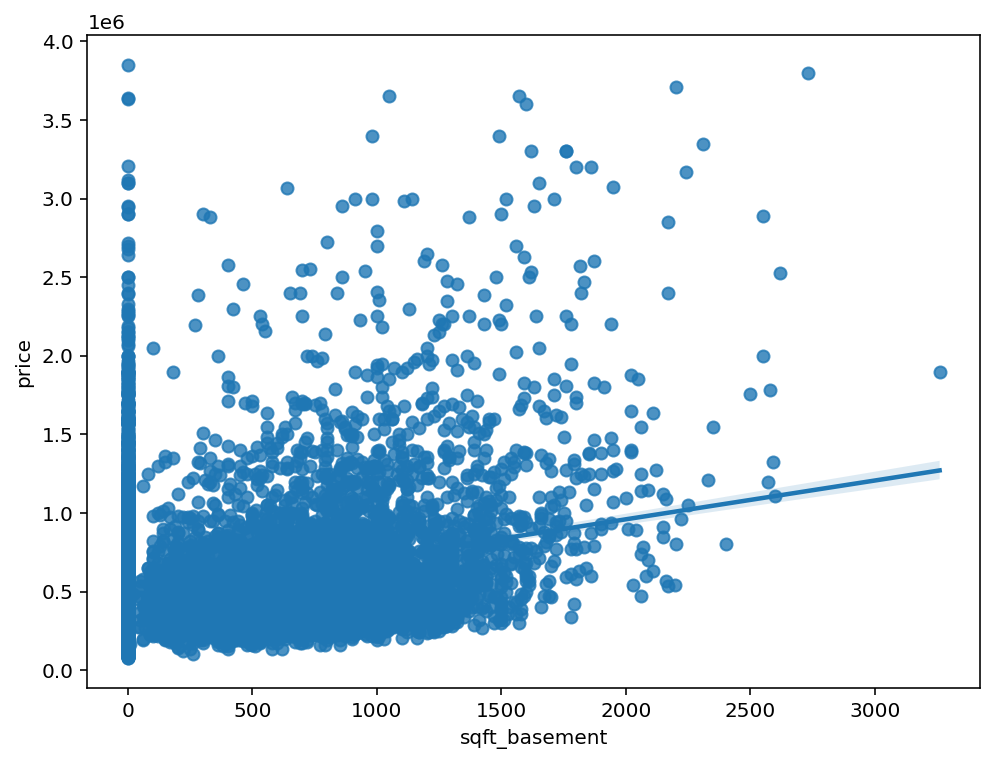

In [ ]:
out_sqft_basement = pd.concat([data['price'], data['sqft_basement']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_basement', y="price", data=out_sqft_basement)

- basement에 따른 outlier도 확인해봅니다.

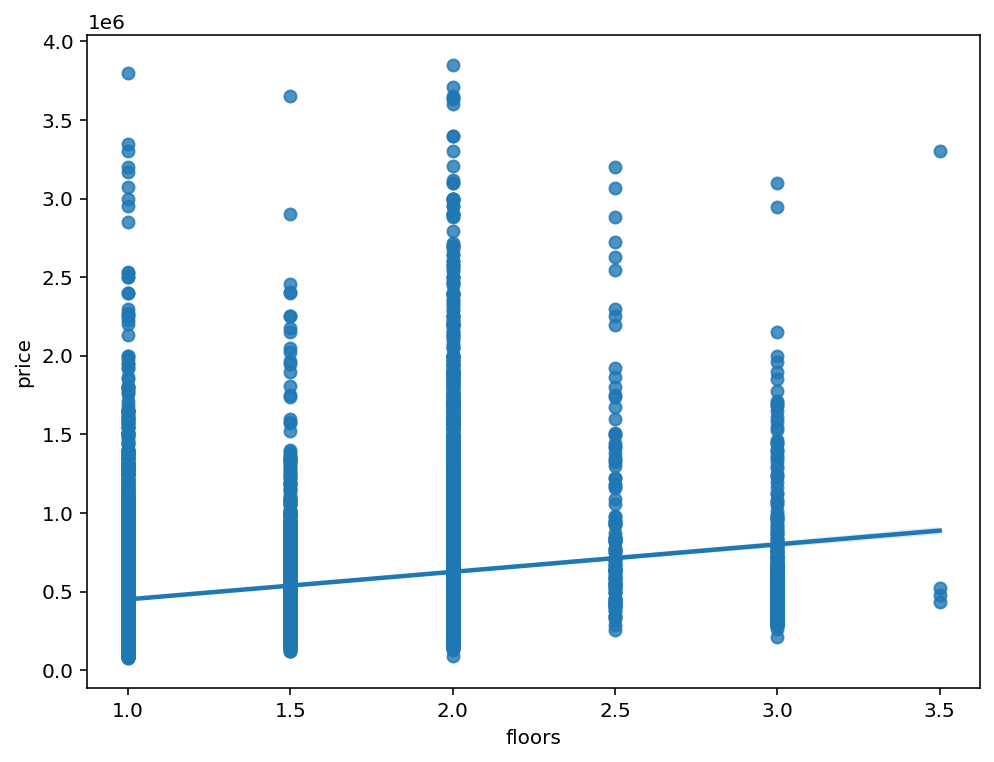

In [ ]:
out_floors= pd.concat([data['price'], data['floors']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='floors', y="price", data=out_floors)

- floors에 따른 outlier도 확인해봅니다.

- outlier를 처리하면서 위에서부터 3~4개 컬럼값에 대한 outliers를 잡아내면 뒤는 알아서 잘 정돈된다는 느낌을 받았습니다.

- 계속 진행합니다.

In [ ]:
print(data.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


2) train, test 데이터 합치기

- 'price' 컬럼은 따로 저장하고 지워줍니다.
- test에는 'price' 컬럼이 없습니다.

In [ ]:
y = data['price']
del data['price']

print(data.columns)
print(test.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- 학습 전 데이터를 살펴보기 위해 concat으로 합쳐줍니다(전처리의 편리함을 위해서도 합쳐서 관리합니다)
- 이때, train의 len 값을 따로 저장해 학습을 진행할 때 데이터 분리에 사용합니다.

In [ ]:
train_len = len(data)
print(train_len)

data = pd.concat((data, test), axis=0)
print(len(data))

15026
21494


- 잘 합쳐진 것을 확인할 수 있습니다.

3)  데이터 결측치 확인

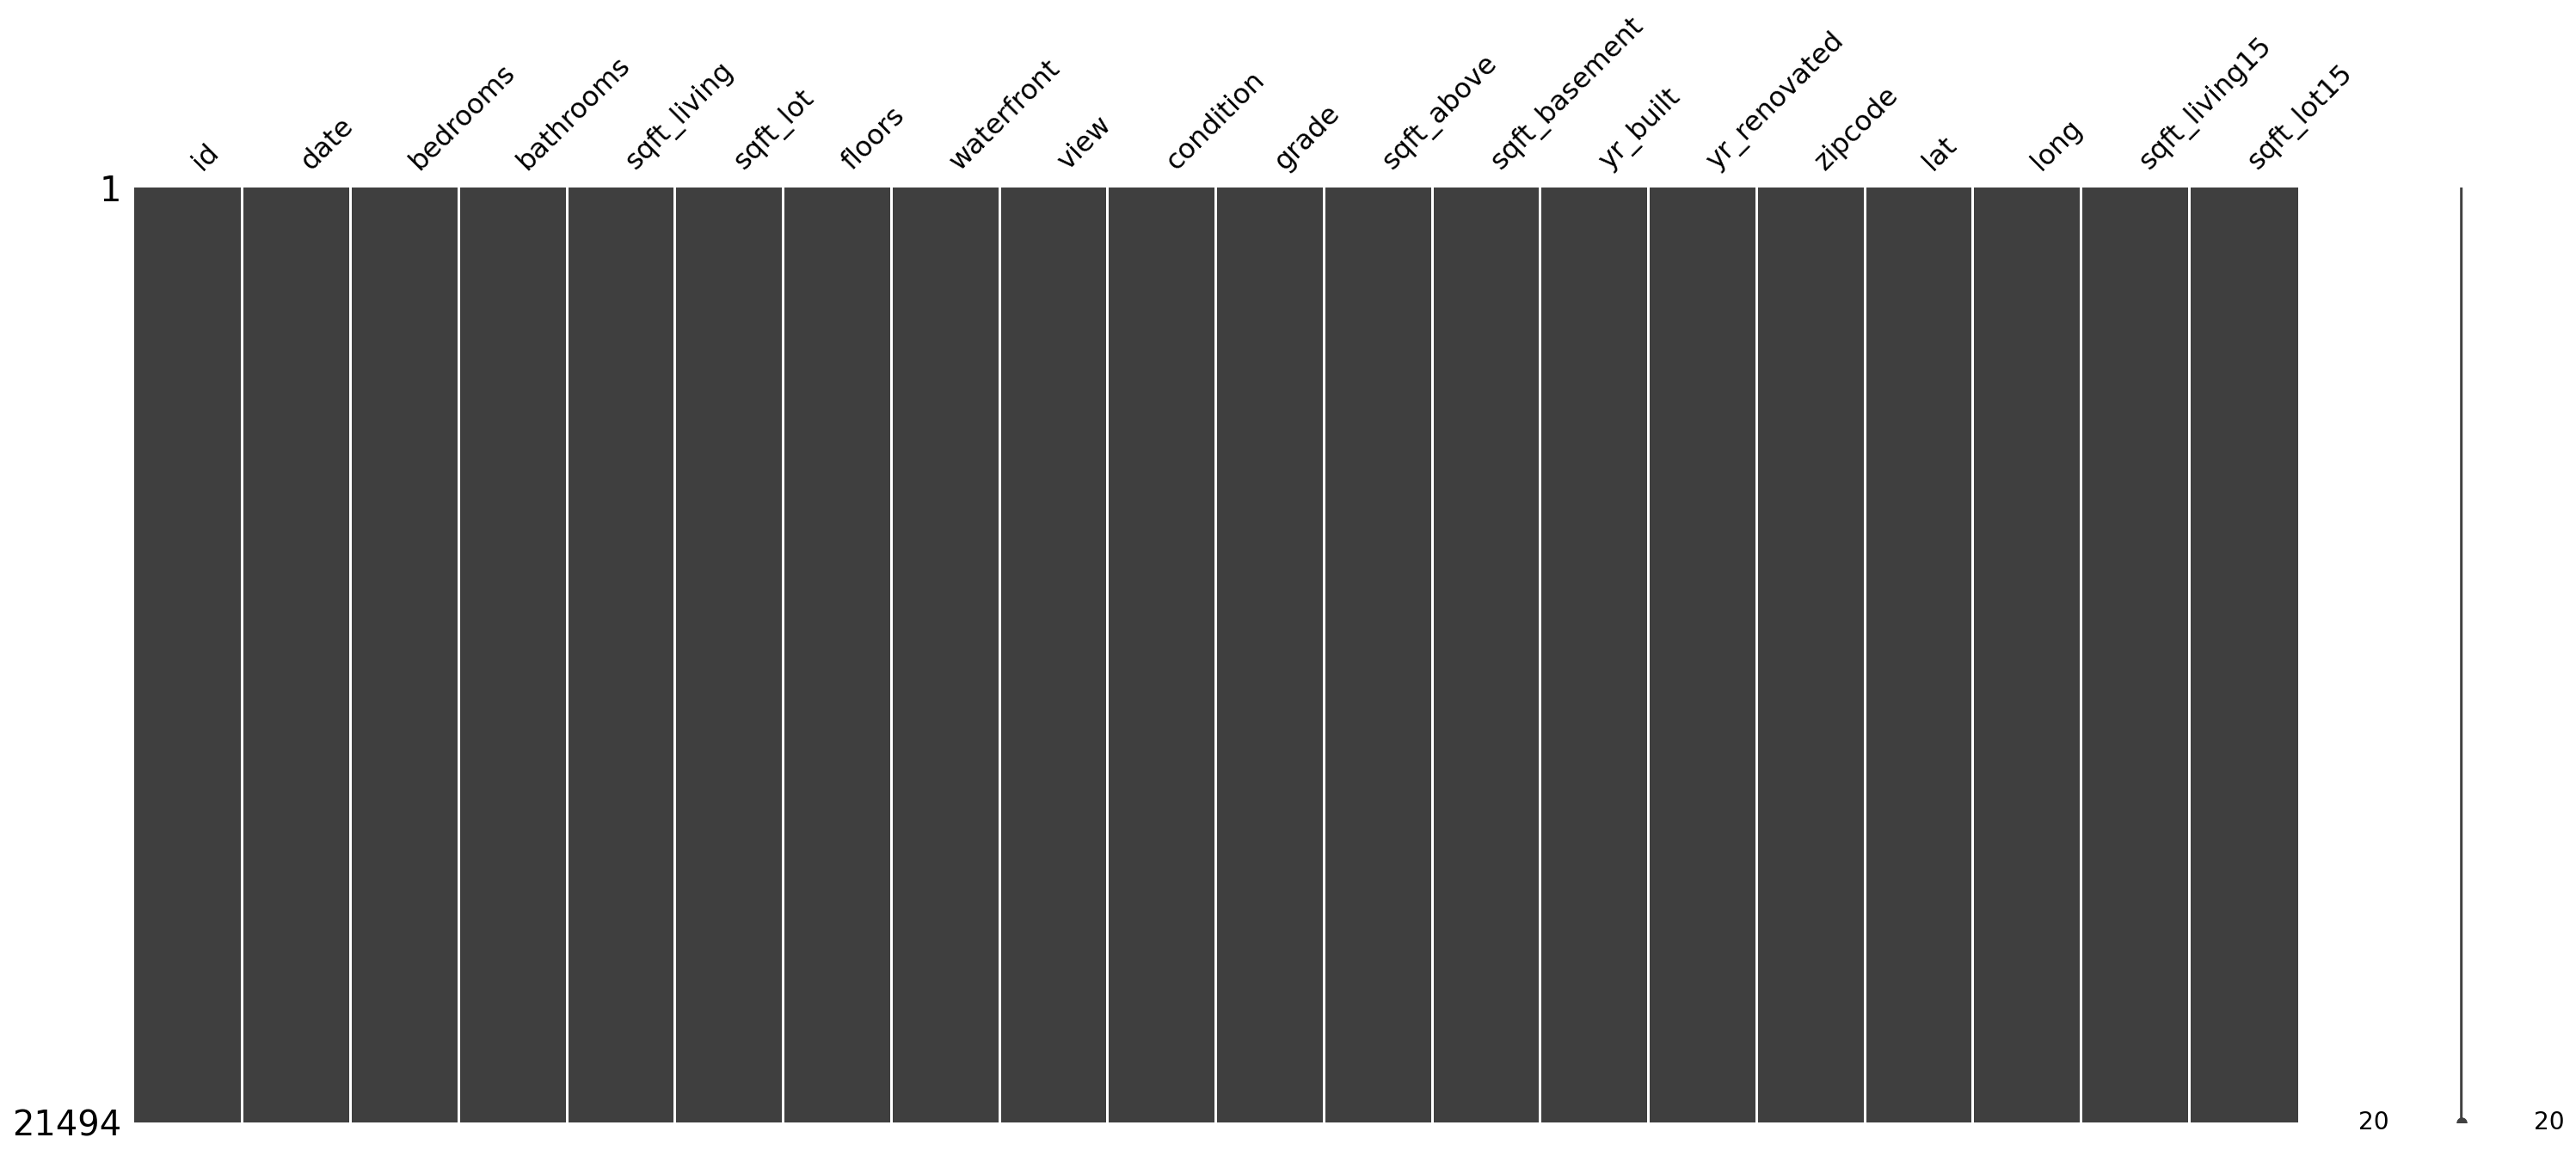

In [ ]:
msno.matrix(data)

- missingno로 봤을 땐 결측치가 없어보이지만 한번 더 확인해봅니다.

In [ ]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


4) 변수 정리

In [ ]:
data.tail(5)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,21502,20150116T000000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


- 'id'는 필요 없는 컬럼입니다. 따로 저장 후 제거합니다.

In [ ]:
test_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- 'date' 컬럼에서 (ex.20140626T000000) 앞 6자리를 제외하고는 불필요한 부분입니다. lambda, apply를 이용해 잘라줍니다.

In [ ]:
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- 잘 정리된 변수들을 확인할 수 있습니다.

#### 1.4.2 Log 변환

1) Skewness(왜도) 
 - 분포의 비대칭성을 나다내는 척도로 대게 절대값이 3 미만이면 기준에 부합한다고 판단합니다.
 -  양의 값이면 왼쪽으로 음의 값이면 오른쪽으로 치우칩니다.  
 - 값이 클수록 데이터의 평균이 정규분포에서 벗어나 있다고 판단할 수 있습니다.

2) Kurtosis(첨도)  
- 샘플의 분포의 상태로 샘플이 평균을 중심으로 가까이 몰려 있을수록 첨도가 커지고 뾰족해집니다.
- 첨도는 0을 중심으로 7 미만이면 기준에 부합한다고 판단합니다. 

- kdeplot을 이용하여 Skewness(왜도)와 Kurtosis(첨도)를 시각화하여 살펴봅니다.

In [ ]:
print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


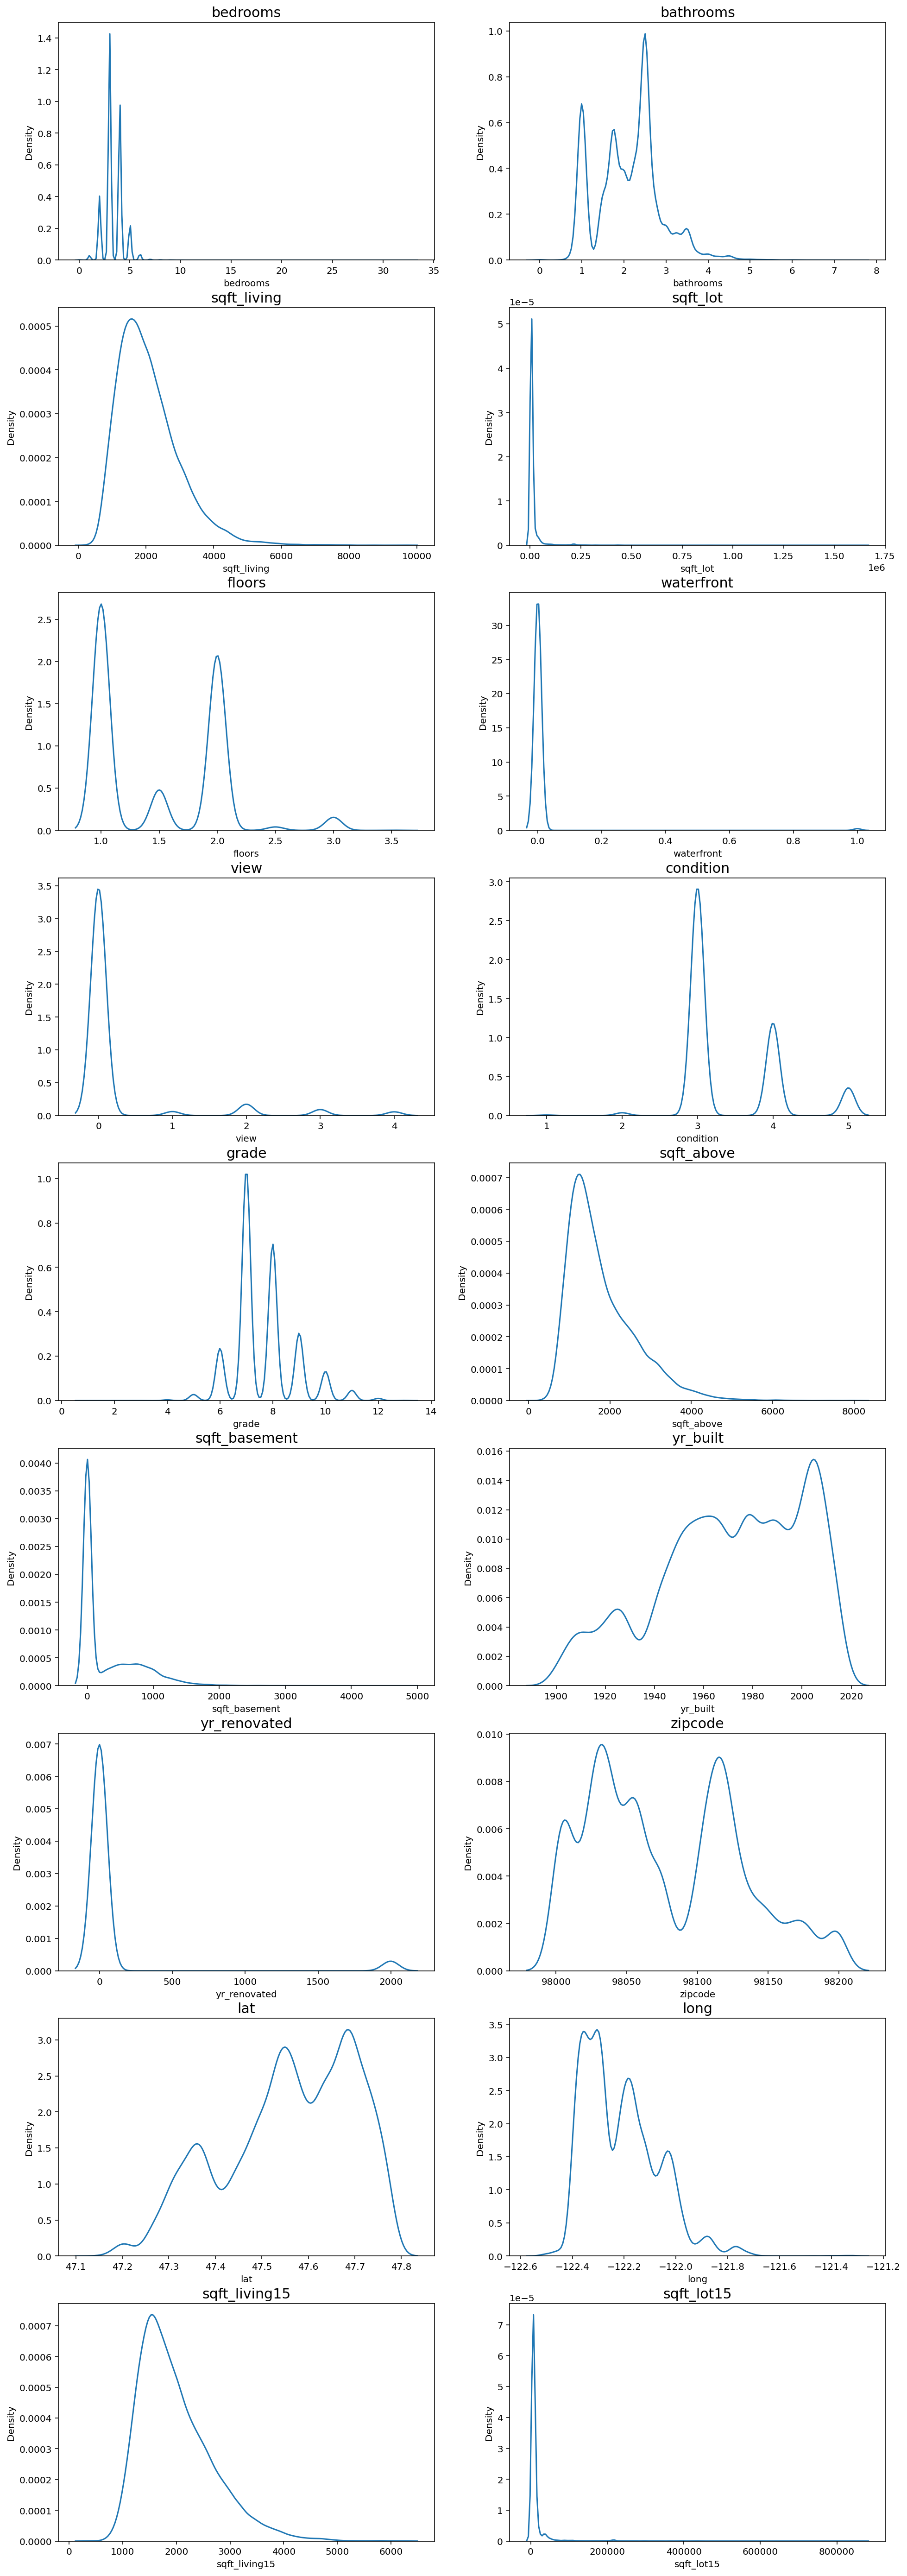

In [ ]:
fig, ax = plt.subplots(9, 2, figsize=(16, 50)) 

count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

- 사실 시각화해서 그래프로만 보면 다 치우쳐진 것 같습니다.  
- 이를 Skewness(왜도)와 Kurtosis(첨도)로 수치화하여 보겠습니다.

In [ ]:
data_features = data.dtypes.index
print(("data_features: ", len(data_features)))

('data_features: ', 19)


In [ ]:
for col in data_features: 
  print('{:15}'.format(col), 
        'Skewness: {:05.2f}'.format(data[col].skew()) , ' ' , 
        'Kurtosis: {:06.2f}'.format(data[col].kurt())
        )

date            Skewness: 00.76   Kurtosis: -01.41
bedrooms        Skewness: 01.99   Kurtosis: 049.54
bathrooms       Skewness: 00.44   Kurtosis: 000.84
sqft_living     Skewness: 01.27   Kurtosis: 002.92
sqft_lot        Skewness: 13.09   Kurtosis: 286.12
floors          Skewness: 00.61   Kurtosis: -00.49
waterfront      Skewness: 11.50   Kurtosis: 130.22
view            Skewness: 03.40   Kurtosis: 010.92
condition       Skewness: 01.04   Kurtosis: 000.52
grade           Skewness: 00.76   Kurtosis: 001.14
sqft_above      Skewness: 01.35   Kurtosis: 002.54
sqft_basement   Skewness: 01.53   Kurtosis: 002.32
yr_built        Skewness: -0.47   Kurtosis: -00.66
yr_renovated    Skewness: 04.54   Kurtosis: 018.65
zipcode         Skewness: 00.41   Kurtosis: -00.85
lat             Skewness: -0.49   Kurtosis: -00.68
long            Skewness: 00.88   Kurtosis: 001.05
sqft_living15   Skewness: 01.10   Kurtosis: 001.59
sqft_lot15      Skewness: 09.53   Kurtosis: 151.42


- Skewness와 Kurtosis를 수치로 확인하고 log 변환 시켜줄 컬럼을 골라냅니다.

- 그 전에 log 변환의 효과를 확인해보려 합니다.

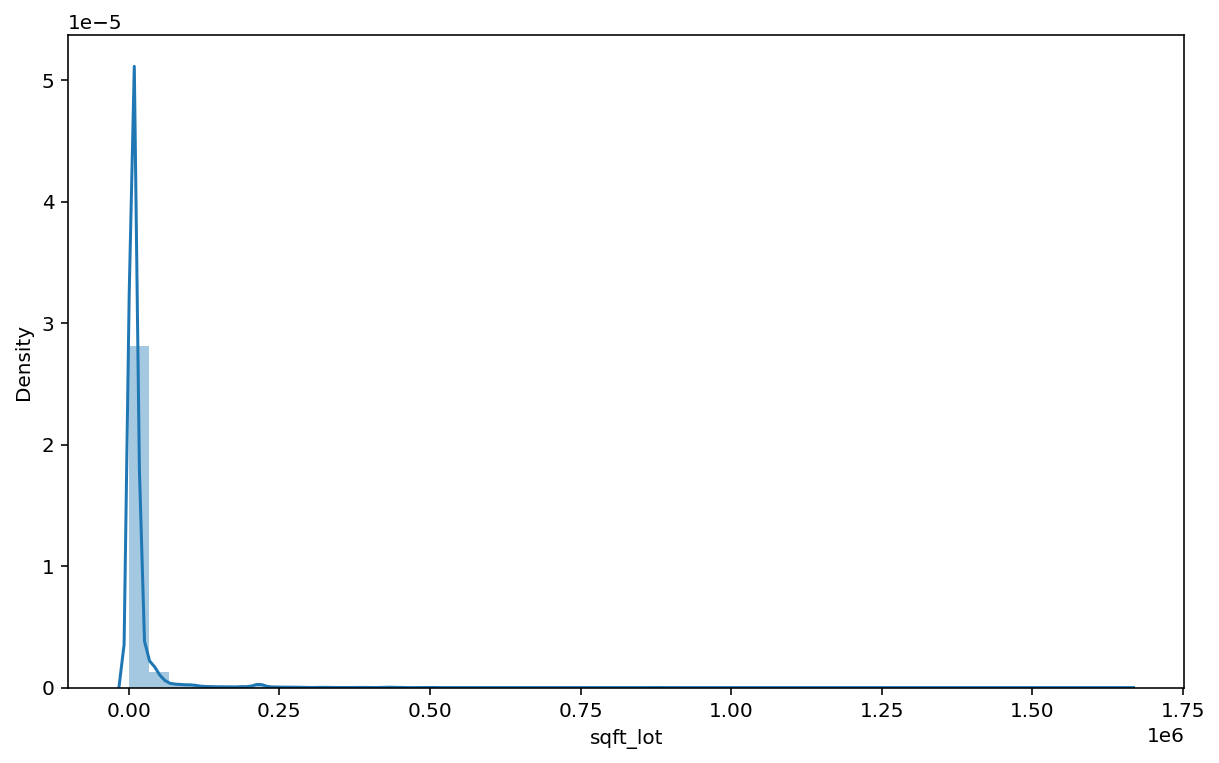

In [ ]:
f, ax = plt.subplots(figsize = (10, 6)) 
sns.distplot(data['sqft_lot'])

- sqft_lot의 skewness와 kurtosis가 높은 만큼 distplot 상에서 치우침과 뾰족함도 심한 것 같습니다. 

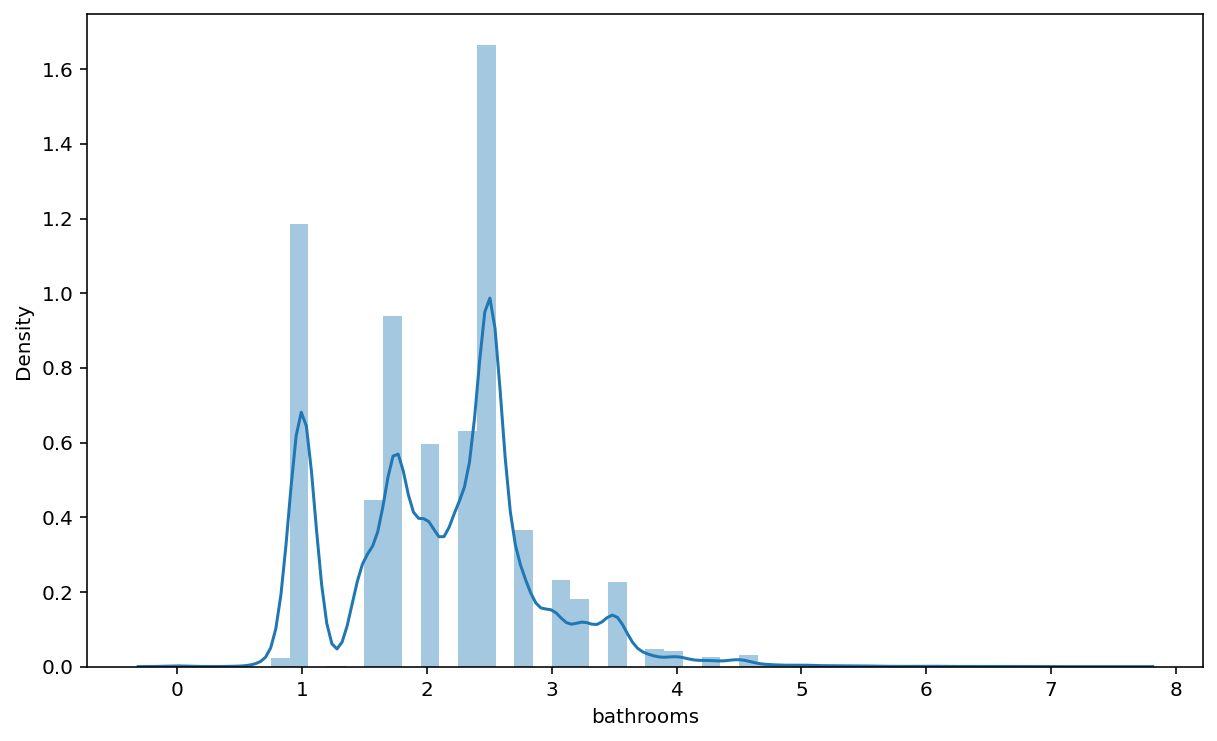

In [ ]:
f, ax = plt.subplots(figsize = (10, 6)) 
sns.distplot(data['bathrooms'])

- 반대로 skewness와 kurtosis가 낮은 bathrooms 같은 경우에는 치우쳐짐이 덜하고 outlier값도 적다고 판단할 수 있습니다.

- stats.probplot은 정규성을 확인하기 위한 방법입니다.
- 왼쪽은 sqft_lot, 오른쪽은 bedrooms 입니다.
- 그래프의 빨간선에 잘 붙어있을 수록 정규분포에 가깝다고 판단할 수 있습니다.

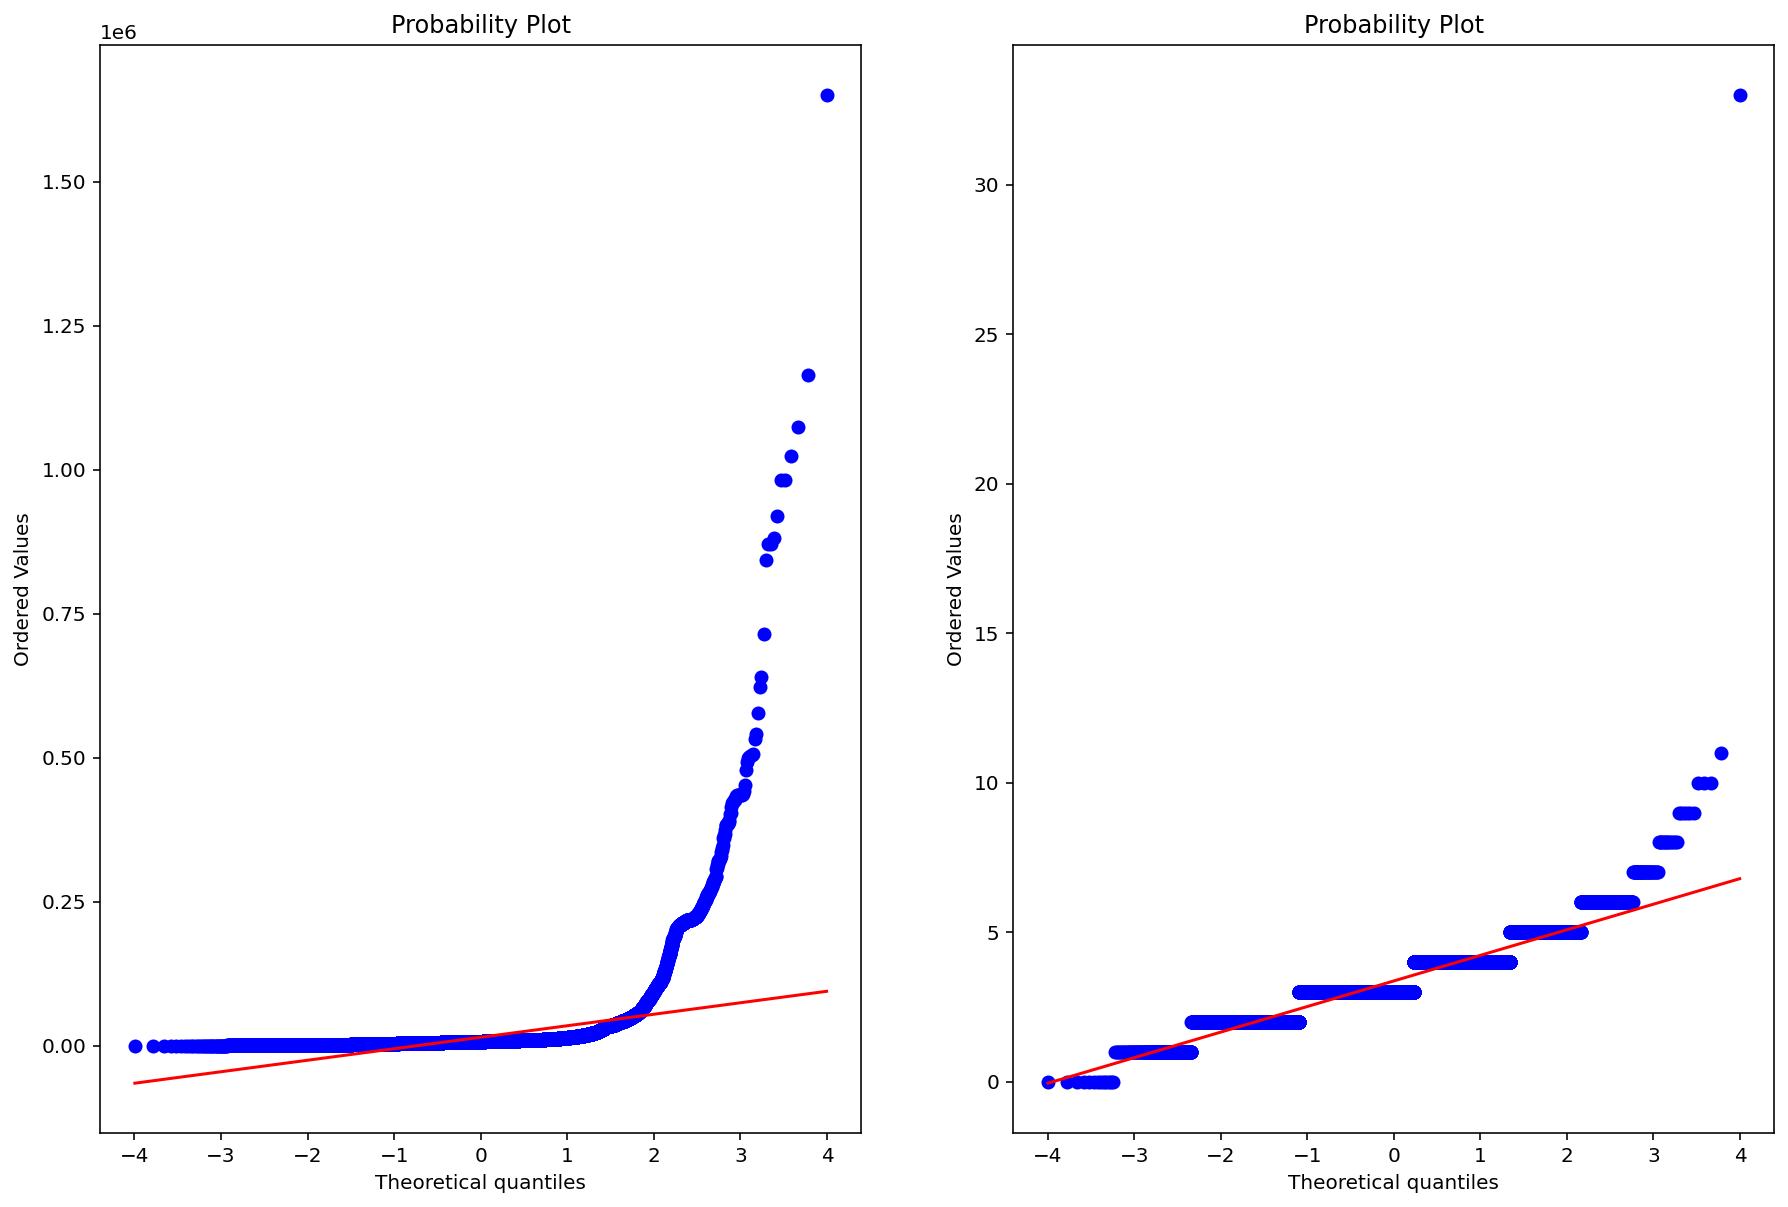

In [ ]:
fig = plt.figure(figsize = (15,10)) 

fig.add_subplot(1,2,1) 
res = stats.probplot(data['sqft_lot'], plot=plt) 

fig.add_subplot(1,2,2) 
res = stats.probplot(data['bedrooms'], plot=plt)

- sqft_lot의 경우에는 정규분포에 가깝다고 보기 어렵고, 반대로 bethrooms의 경우에는 상당히 정규분포와 잘 맞는 모습을 볼 수 있습니다.

- log 변환의 효과를 보기 위해 sqft_lot의 로그 변환 값을 log_sqft_lot에 저장해서 비교해보겠습니다.

In [ ]:
data["Log_sqft_lot"] = np.log1p(data["sqft_lot"])

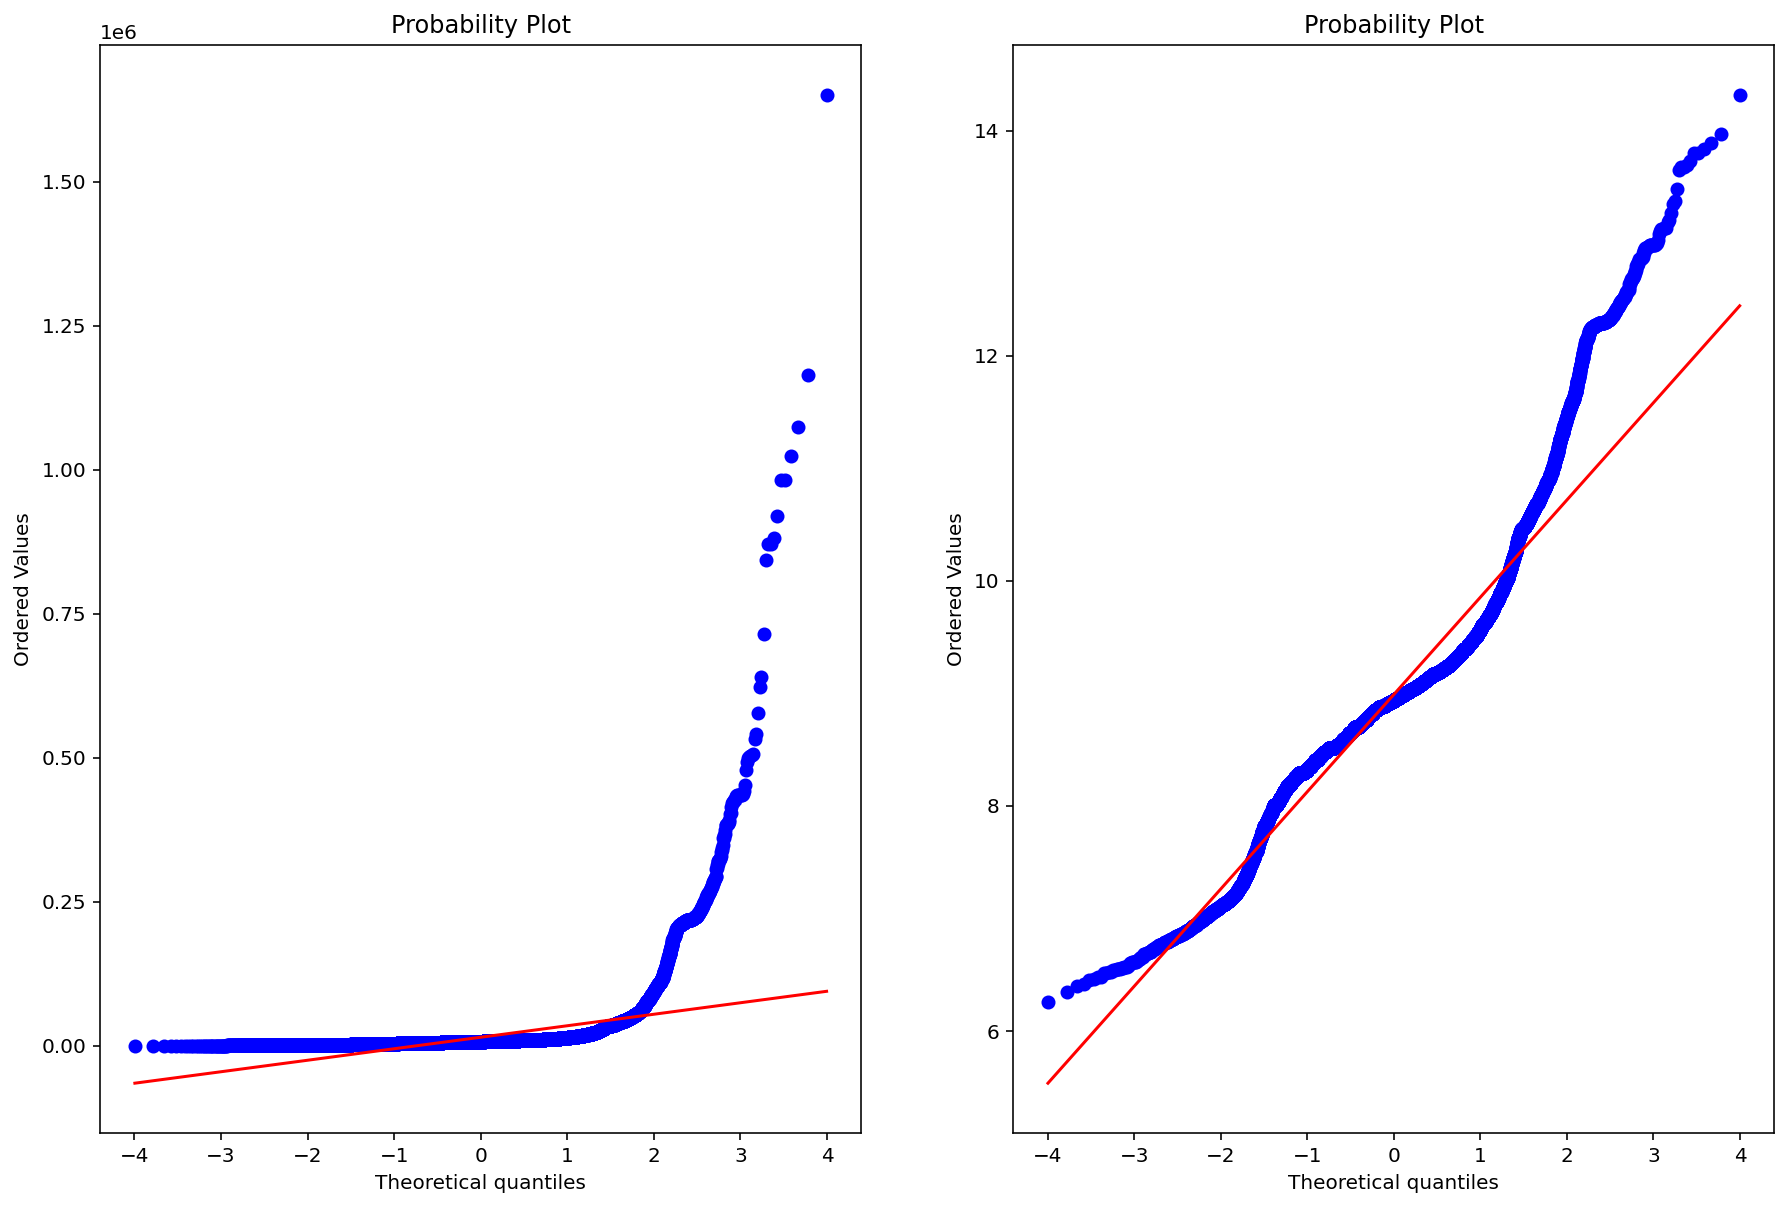

In [ ]:
fig = plt.figure(figsize = (15,10)) 

fig.add_subplot(1,2,1) 
res = stats.probplot(data['sqft_lot'], plot=plt) 

fig.add_subplot(1,2,2) 
res = stats.probplot(data['Log_sqft_lot'], plot=plt)

- 확실히 log 변환 후 정규분포와 잘 맞는 모습을 볼 수 있습니다.

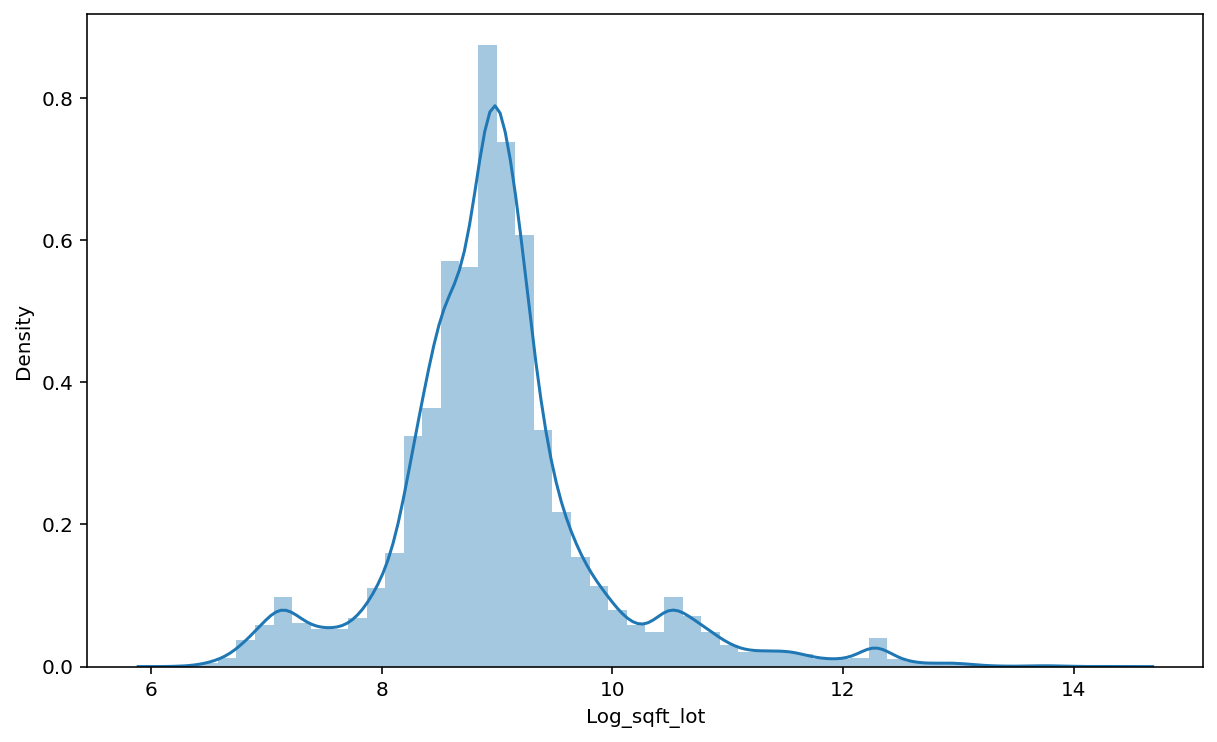

In [ ]:
f, ax = plt.subplots(figsize = (10, 6)) 
sns.distplot(data['Log_sqft_lot'])

- 시각화를 해보면 왜도와 첨도 모두 줄어든 것 같습니다.

- 비교가 끝났으니 log_sqft_lot은 삭제합니다.

In [ ]:
data = data.drop(['Log_sqft_lot'], axis=1)

- 나머지 튀는 값들에 log변환을 시켜줍니다.

- 제가 선택한 컬럼은 bedrooms, sqft_lot, sqft_lot15 총 3개입니다.

In [ ]:
skew_columns = ['bedrooms', 'sqft_lot', 'sqft_lot15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

- y에 저장한 price 값도 살펴봅니다.

In [ ]:
  print('Price |', 'Skewness: {:05.2f}'.format(y.skew()) , ' ' , 
        'Kurtosis: {:06.2f}'.format(y.kurt())
        )

Price | Skewness: 03.00   Kurtosis: 014.69


- y에 저장한 data 컬럼의 price도 치우쳐진 모습을 보입니다.

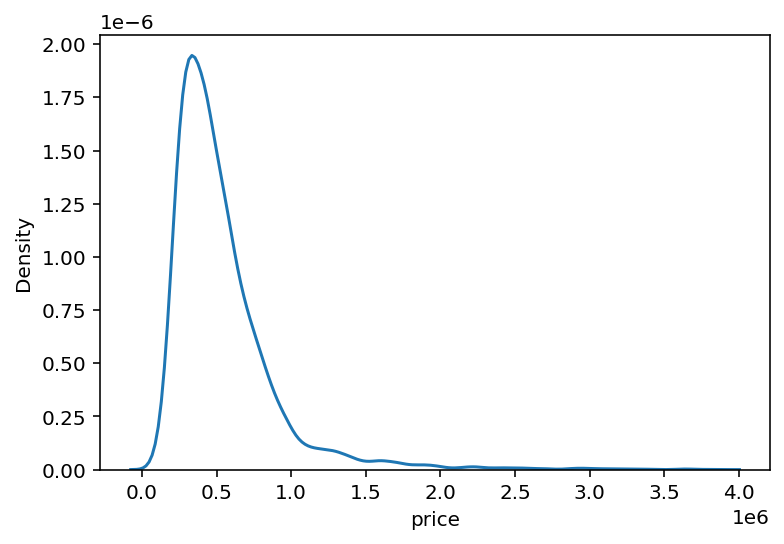

In [ ]:
sns.kdeplot(y)
plt.show()

- 정규분포와 잘 맞는지 확인해봅니다.

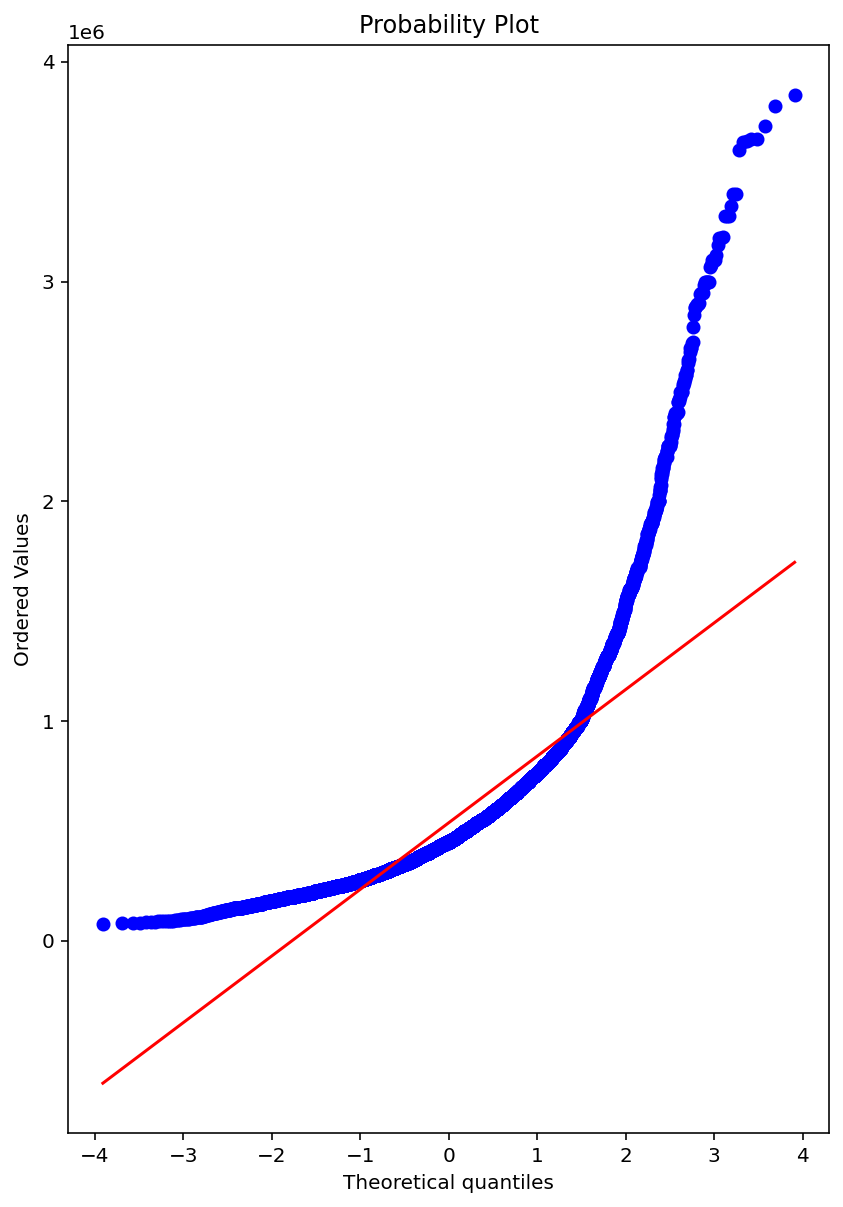

In [ ]:
fig = plt.figure(figsize = (15,10)) 

fig.add_subplot(1,2,1) 
res = stats.probplot(y, plot=plt) 

- log 변환을 진행합니다.

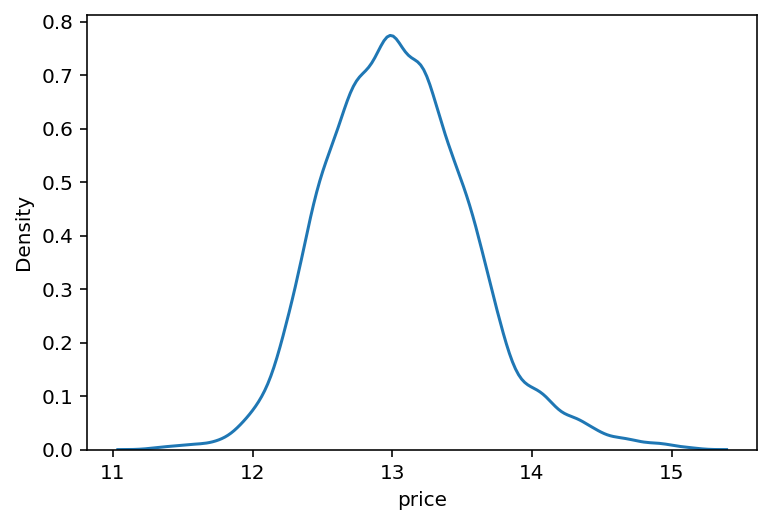

In [ ]:
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

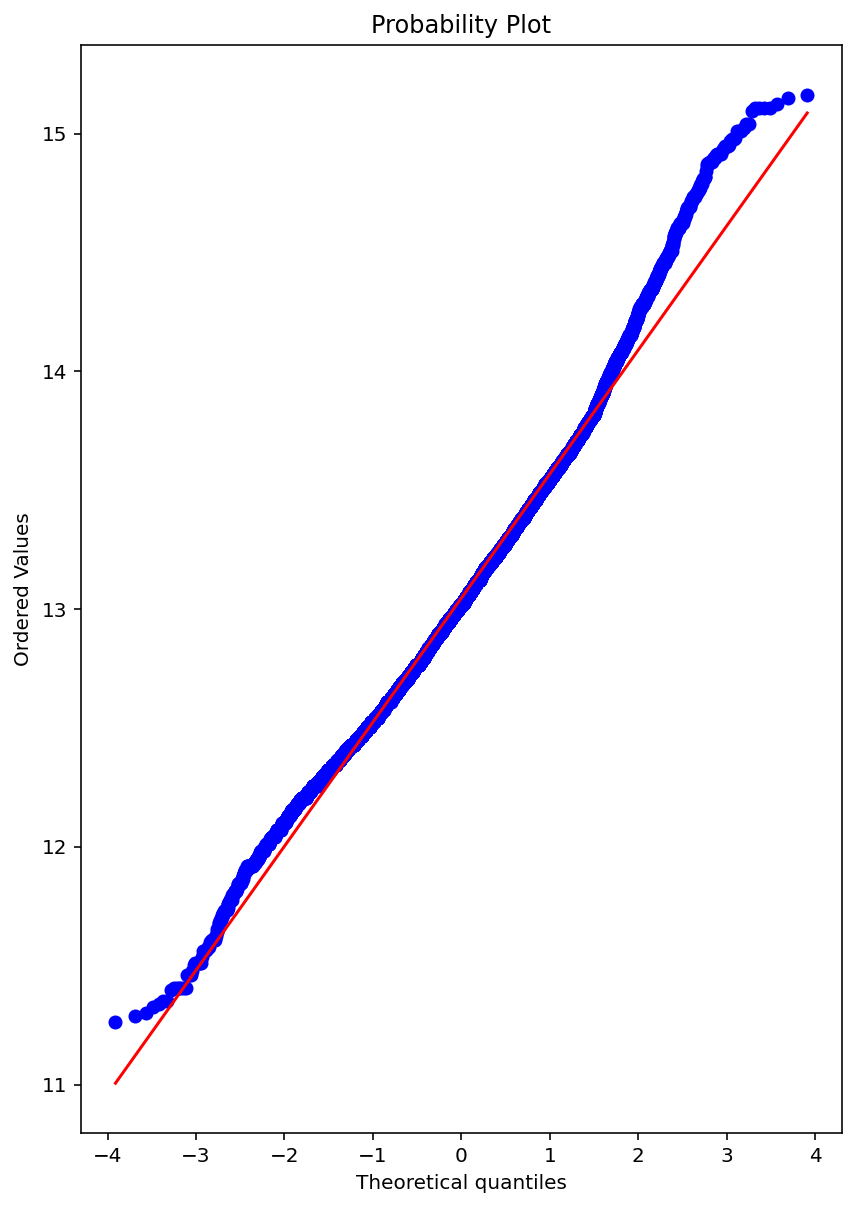

In [ ]:
fig = plt.figure(figsize = (15,10)) 

fig.add_subplot(1,2,1) 
res = stats.probplot(y, plot=plt) 

- 잘 맞는 것 같습니다. 넘어갑니다.

- 모든 작업이 끝났습니다.

#### 1.4.3 train, test 데이터 분리

1) 데이터 분리

- train_len에 저장한 범위를 이용해 다시 train, test 데이터를 분리합니다.

In [ ]:
print('train data dim : {}'.format(data.shape))

train data dim : (21494, 19)


In [ ]:
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15026, 19)
test data dim : (6468, 19)


2) 모델 훈련

- 사전에 정의한 get_scores 함수를 바탕으로 훈련하고 결과를 보여줍니다. 

In [ ]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,139823.958105
RandomForestRegressor,135608.406229
LGBMRegressor,122967.915396
XGBRegressor,120356.655902


- 목표는 RMSE 110,000 이하입니다. 

3) 데이터 확인

- 분명 놓치는 것이 있을테니 데이터를 다시 살펴봅니다.

In [ ]:
data_s = train

In [ ]:
data_s['Price'] = y

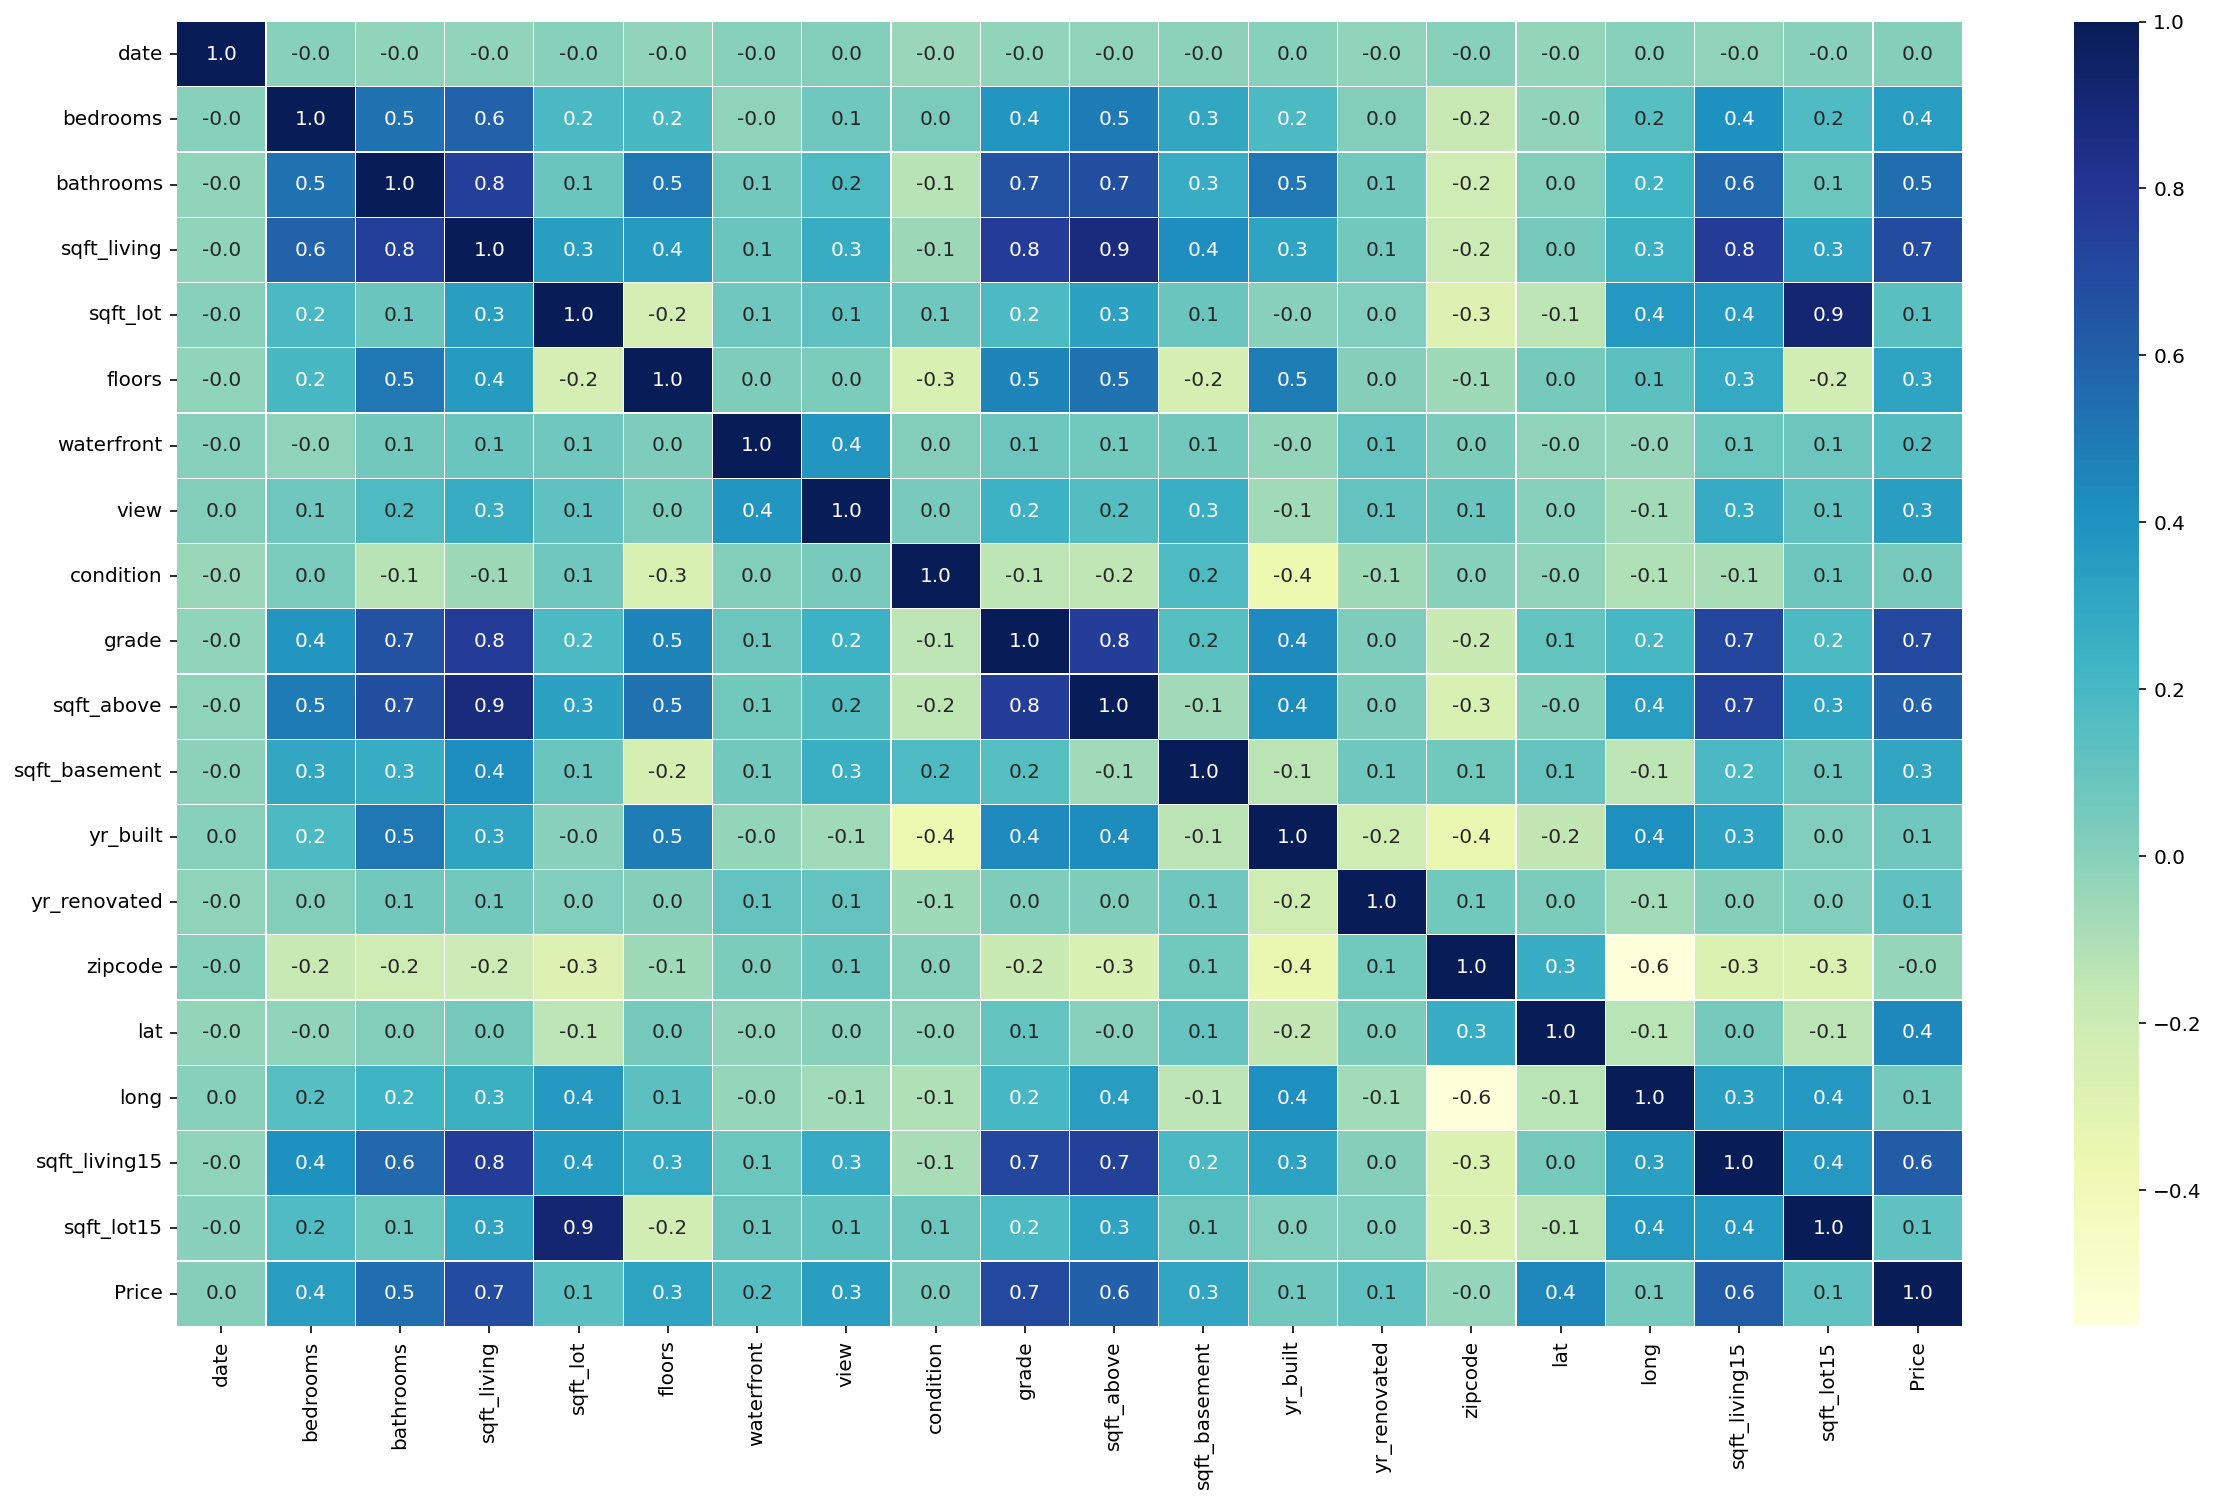

In [ ]:
corr_data = data_s.corr()
fig, ax = plt.subplots(figsize=(20,12))

sns.heatmap(data=corr_data, ax=ax, linewidths=0.1, linecolor='white', annot=True, cmap='YlGnBu', fmt='.1f')
plt.show()

- 아래 3개의 컬럼이 신경쓰입니다.
- yr_built : 지어진 년도  
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호

- 통상적으로 보면 재건축도 분명 집값과 관계가 있을겁니다.
- 재건축 년도에서 지어진 년도를 뺀 값이 음수면 0, 양수면 1로 표시하면 재건축 여부를 판단할 수 있을 것 같습니다.

In [ ]:
print('train data dim : {}'.format(data.shape))

train data dim : (21494, 19)


In [ ]:
data['renovated'] = data['yr_renovated'] - data['yr_built']
data['renovated'] = data['renovated'].apply(lambda x: 0 if x < 0 else 1)

In [ ]:
print('data dim : {}'.format(data.shape))
print('============================================')
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

data dim : (21494, 20)
train data dim : (15026, 20)
test data dim : (6468, 20)


In [ ]:
print(data['renovated'].value_counts())

0    20583
1      911
Name: renovated, dtype: int64


- 그 다음 살펴볼 데이터는 zipcode 입니다.
- 우편주소의 존재 의미는 지역입니다. 우리도 서울과 지방의 집값 차이가 있는 것처럼 사람 사는 곳은 다 그런겁니다.

- uszipcode라이브러리를 불러온 이유가 여기에 있습니다

- zipcode를 counting하고, 사전에 정의한 zco 함수로 도시 이름으로 변환합니다.

In [ ]:
print(data['zipcode'].value_counts())

98103    600
98038    587
98115    578
98052    571
98117    550
        ... 
98102    104
98010     99
98024     80
98148     56
98039     47
Name: zipcode, Length: 70, dtype: int64


In [ ]:
data['city'] = data['zipcode'].apply(zco)

In [ ]:
print(data['city'].value_counts())

Seattle          8920
Renton           1591
Bellevue         1396
Kent             1197
Kirkland          976
Redmond           974
Auburn            910
Sammamish         794
Federal Way       772
Issaquah          730
Maple Valley      587
Woodinville       469
Snoqualmie        308
Kenmore           283
Mercer Island     281
Enumclaw          234
North Bend        220
Bothell           195
Duvall            190
Carnation         124
Vashon            117
Black Diamond      99
Fall City          80
Medina             47
Name: city, dtype: int64


- 이 데이터에는 24개 도시가 존재합니다.

In [ ]:
print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'renovated', 'city'],
      dtype='object')


- 24개의 도시를 각각 컬럼으로 분리합니다. 

In [ ]:
data = pd.get_dummies(data, columns=['city'])

In [ ]:
data = data.drop(['zipcode'], axis=1)

In [ ]:
print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'renovated', 'city_Auburn',
       'city_Bellevue', 'city_Black Diamond', 'city_Bothell', 'city_Carnation',
       'city_Duvall', 'city_Enumclaw', 'city_Fall City', 'city_Federal Way',
       'city_Issaquah', 'city_Kenmore', 'city_Kent', 'city_Kirkland',
       'city_Maple Valley', 'city_Medina', 'city_Mercer Island',
       'city_North Bend', 'city_Redmond', 'city_Renton', 'city_Sammamish',
       'city_Seattle', 'city_Snoqualmie', 'city_Vashon', 'city_Woodinville'],
      dtype='object')


- 잘 나뉘었습니다.

- 다시 data를 test와 train으로 분리합니다.

In [ ]:
print('data dim : {}'.format(data.shape))
print('============================================')
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

data dim : (21494, 43)
train data dim : (15026, 43)
test data dim : (6468, 43)


#### 1.4.4 하이퍼 파라미터 튜닝

- 사이킷런의 GridSearchCV를 이용해 하이퍼 파라미터 값을 수정합니다.

- 이 작업을 통해 더 좋은 score를 올리는 것이 목적입니다.

- 모델은 LGBM을 사용하고 사전에 정의한 my_GridSearch 함수를 통해 결과까지 확인합니다.

1) 파라미터 설정

- 여러 파라미터들이 있지만 너무 많이 설정해서 돌리면 오늘 안에 확인 못할겁니다.
- n_estimators : 결정트리 갯수를 지정합니다.
- max_depth : Tree의 최대 깊이를 말하며, 과적합을 다룰 때 사용합니다. 과적합이라고 느끼면 값을 줄여주면 됩니다.
- learning_rate : 우리가 알고있는 그 학습률 맞습니다.
- num_iteration : 반복 수행 횟수입니다.

- 트리 갯수와, 학습률, 반복에 중점을 두고 돌려봅니다.

In [ ]:
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [6, 12, 15], 
    'learning_rate': [0.01, 0.001, 0.0001],
    'num_iteration': [5000, 10000, 20000]
}

model = LGBMRegressor(random_state=22)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


,learning_rate,max_depth,n_estimators,num_iteration,score,RMSLE
9,0.0100,12,150,5000,-0.025681,0.160252
6,0.0100,12,100,5000,-0.025681,0.160252
15,0.0100,15,150,5000,-0.025700,0.160313
12,0.0100,15,100,5000,-0.025700,0.160313
0,0.0100,6,100,5000,-0.025729,0.160402
3,0.0100,6,150,5000,-0.025729,0.160402
29,0.0010,12,150,20000,-0.025751,0.160471
26,0.0010,12,100,20000,-0.025751,0.160471
32,0.0010,15,100,20000,-0.025753,0.160477
35,0.0010,15,150,20000,-0.025753,0.160477


- 오래걸립니다...

2) LGBMRegressor 학습

- 가장 결과가 좋은 파라미터를 적용하여 모델을 훈련시킵니다.

In [ ]:
model = LGBMRegressor(n_estimators = 150
                      ,max_depth = 12
                      ,learning_rate = 0.01
                      ,num_iteration = 10000
                      ,random_state = 22
                      )
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] num_iterations is set=10000, num_iteration=10000 will be ignored. Current value: num_iterations=10000


array([13.17763776, 13.0765303 , 14.06602088, ..., 13.0804679 ,
       12.6976497 , 12.97969483])

3) 결과 확인

- y에 log 변환을 했으므로 다시 원상태로 돌려주어 확인합니다.

In [ ]:
prediction = np.expm1(prediction)
prediction

array([ 528414.27400445,  477599.69915532, 1284679.84927254, ...,
        479484.00585201,  326977.50053424,  433519.70203992])

- 결과가 잘 나온 것 같습니다.

4) 업로드 데이터 시트

In [ ]:
submission = pd.read_csv('https://raw.githubusercontent.com/Chae0220/AI_Study/main/data/house_sample_submission.csv')

- 캐글에서 제공하는 업로드용 시트를 준비하여 안에 있는 값들을 살펴봅니다.

In [ ]:
submission.head(5)

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


- price를 뽑아낸 예측값으로 바꿔줘야합니다.

In [ ]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.284143e+05
1,15036,4.775997e+05
2,15037,1.284680e+06
3,15038,2.802798e+05
4,15039,3.285905e+05


- 잘 바뀌었습니다.

5) 데이터 저장 및 업로드

- 구글 코랩을 사용중이므로 구글 드라이브에 마운트해 바로 올릴 수 있도록 준비합니다.

In [ ]:
drive.mount('/gdrive')

In [ ]:
submission.to_csv('/gdrive/My Drive/Colab Notebooks/data/submission16.csv', index=False)

- 모든 준비는 끝났고 데이터를 올려봅니다.
  (16번 시도해 목표치를 달성했습니다...)

<img src = "https://drive.google.com/uc?id=1ql04R-OQUoPVeUQsRlhJohGAg4GsIlzz" height = 588 width = 900>

# 2. 회고

- EDA는 매우 중요하다.   
(좋은 분석을 통해 전처리가 잘 이루어지면 하이퍼 파라미터값을 수정 하지 않아도 좋은 결과가 나오기 때문입니다.)

- 그리드 서치가 만능은 아니다.  
(같은 맥락입니다. 들어가는 데이터가 양질이 아니면 큰 도움이 안 된다고 느꼈습니다.) 

- 시각화도 많은 공부가 필요하다.  
(생각하는 바를 표현할 시각화 방법이 있는데 몰라서 못 찾는 답답함을 느꼈습니다.)

# 3. References

- 아래의 페이지에서 많은 도움을 받았습니다.

- https://sites.google.com/view/lauraepp/parameters
- https://nicola-ml.tistory.com/51
- https://zzinnam.tistory.com/entry/XGBoost-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-%EC%A1%B0%EC%A0%95%ED%8A%9C%EB%8B%9D
- https://pypi.org/project/uszipcode/
- https://www.pythonpool.com/uszipcode-python/
- https://stackoverflow.com/questions/50355778/is-there-a-python-library-that-would-return-a-city-when-provided-with-zip-code
- https://matplotlib.org/stable/tutorials/colors/colormaps.html